# Setup

In [1]:
# copied from Neel, so you can download the notebook to colab
# Janky code to do different setup when run in a Colab notebook vs VSCode
DEVELOPMENT_MODE = False
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
    %pip install git+https://github.com/neelnanda-io/TransformerLens.git
    %pip install circuitsvis
    %pip install einops
    
    # PySvelte is an unmaintained visualization library, use it as a backup if circuitsvis isn't working
    # # Install another version of node that makes PySvelte work way faster
    # !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
    # %pip install git+https://github.com/neelnanda-io/PySvelte.git
except:
    IN_COLAB = False
    print("Running as a Jupyter notebook - intended for development only!")
    from IPython import get_ipython

    ipython = get_ipython()
    # Code to automatically update the HookedTransformer code as its edited without restarting the kernel
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")

Running as a Jupyter notebook - intended for development only!


/tmp/ipykernel_78792/208674140.py:23: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("load_ext autoreload")
/tmp/ipykernel_78792/208674140.py:24: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("autoreload 2")


In [2]:
from transformer_lens import HookedTransformer, HookedTransformerConfig
import plotly.express as px
import plotly.io as pio

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import tqdm.auto as tqdm
import einops
from transformer_lens.utils import to_numpy

np.random.seed(0)
torch.manual_seed(1)

In [3]:
# copied from Neel
# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio
pio.renderers.default = "notebook_connected"
print(f"Using renderer: {pio.renderers.default}")

Using renderer: notebook_connected


## Load model


In [4]:
p = 113  # the range of the model inputs
lr=5e-4
weight_decay = 1.0
d_model = 128 # 128
frac_train = 0.5
num_epochs = 5000
stopping_thresh = -1
seed = 0
num_layers = 1
batch_style = 'full'
d_vocab = p + 1
n_ctx = 3
d_mlp = 8 * d_model  # 4*d_model
num_heads = 8 # 4
assert d_model % num_heads == 0
d_head = d_model//num_heads
act_type = 'ReLU' # ['ReLU', 'GeLU']
use_ln = False

In [5]:
cfg = HookedTransformerConfig(
    n_layers=num_layers,
    d_model=d_model,
    d_head=d_model//num_heads,
    n_heads=num_heads,
    d_mlp=8*d_model,
    d_vocab=p+1,
    n_ctx=3,
    act_fn="relu",
    normalization_type=None,
)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)
SEED=1
torch.manual_seed(SEED)
model = HookedTransformer(cfg).to(DEVICE)

cpu
Moving model to device:  cpu


In [6]:
# mount drive
#from google.colab import drive
#import time
#drive.mount("/content/drive", force_remount=True) 

file_location = './'
weight_file_location = file_location + 'transformer_model.pt'
label_file_location = file_location + "transformer_label_info.pkl"

DEVICE = torch.device('cpu')

In [7]:
old_model_dict = torch.load(weight_file_location, map_location=torch.device('cpu'))["model"]
print(old_model_dict.keys())

new_model_dict = {
    "embed.W_E":old_model_dict["embed.W_E"].T,
    "blocks.0.attn.W_Q":old_model_dict["blocks.0.attn.W_Q"].transpose(1,2),
    "blocks.0.attn.W_K":old_model_dict["blocks.0.attn.W_K"].transpose(1,2),
    "blocks.0.attn.W_V":old_model_dict["blocks.0.attn.W_V"].transpose(1,2),
    "blocks.0.attn.W_O":old_model_dict["blocks.0.attn.W_O"].T.view((num_heads, d_head, d_model)),
    "blocks.0.mlp.W_in":old_model_dict["blocks.0.mlp.W_in"].T,
    "blocks.0.mlp.W_out":old_model_dict["blocks.0.mlp.W_out"].T,
    "blocks.0.attn.b_Q":torch.zeros((num_heads, d_head)),
    "blocks.0.attn.b_K":torch.zeros((num_heads, d_head)), 
    "blocks.0.attn.b_V":torch.zeros((num_heads, d_head)), 
    "blocks.0.attn.b_O":torch.zeros((d_model)), 
    "blocks.0.attn.IGNORE":torch.zeros(()) - 1e10, 
    "unembed.b_U":torch.zeros(p+1),
    "pos_embed.W_pos":old_model_dict["pos_embed.W_pos"], 
    "blocks.0.attn.mask":old_model_dict["blocks.0.attn.mask"], 
    "blocks.0.mlp.b_in":old_model_dict["blocks.0.mlp.b_in"], 
    "blocks.0.mlp.b_out":old_model_dict["blocks.0.mlp.b_out"], 
    "unembed.W_U":old_model_dict["unembed.W_U"]
}

odict_keys(['embed.W_E', 'pos_embed.W_pos', 'blocks.0.attn.W_K', 'blocks.0.attn.W_Q', 'blocks.0.attn.W_V', 'blocks.0.attn.W_O', 'blocks.0.attn.mask', 'blocks.0.mlp.W_in', 'blocks.0.mlp.b_in', 'blocks.0.mlp.W_out', 'blocks.0.mlp.b_out', 'unembed.W_U'])


In [8]:
model.load_state_dict(new_model_dict)
model.to(DEVICE)

Moving model to device:  cpu


HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0): TransformerBlock(
      (ln1): Identity()
      (ln2): Identity()
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_resid_pre): HookPoint()
      (hook_resid_mid): HookPoint()
      (hook_resid_post): HookPoint()
    )
  )
  (unembed): Unembed()
)

In [9]:
import random

def gen_train_test(frac_train, seed=0):
    # Generate train and test split
    pairs = [(i, j, p) for i in range(p) for j in range(p)]
    random.seed(seed)
    random.shuffle(pairs)
    div = int(frac_train*len(pairs))
    return pairs[:div], pairs[div:]

train, test = gen_train_test(frac_train, seed)
all_pairs = [(i, j, p) for i in range(p) for j in range(p)]
print(len(train), len(test))

6384 6385


In [10]:
# Creates an array of Boolean indices according to whether each data point is in 
# train or test
# Used to index into the big batch of all possible data
is_train = []
is_test = []
for x in range(p):
    for y in range(p):
        if (x, y, p) in train:
            is_train.append(True)
            is_test.append(False)
        else:
            is_train.append(False)
            is_test.append(True)
is_train = np.array(is_train)
is_test = np.array(is_test)

In [11]:
import pickle

with open(label_file_location, 'rb') as f:
    label_info = pickle.load(f)
ground_truth_labels = label_info['labels']

In [12]:
logits = model(torch.tensor(all_pairs).to(DEVICE))[:, -1]
model_labels = np.zeros((p, p))
for x in range(p):
    for y in range(p):
        if logits[x*p + y][0] < logits[x*p + y][1]:
            model_labels[x][y] = 1
accuracy = 1 - 2 * np.mean(np.abs(ground_truth_labels - model_labels))
fraction_correct = 1 - np.mean(np.abs(ground_truth_labels - model_labels))
print('Accuracy on test half:', accuracy)
print('Fraction correct:', fraction_correct)

Accuracy on test half: 0.9727464954185919
Fraction correct: 0.9863732477092959


Text(0.5, 1.0, 'Model Outputs')

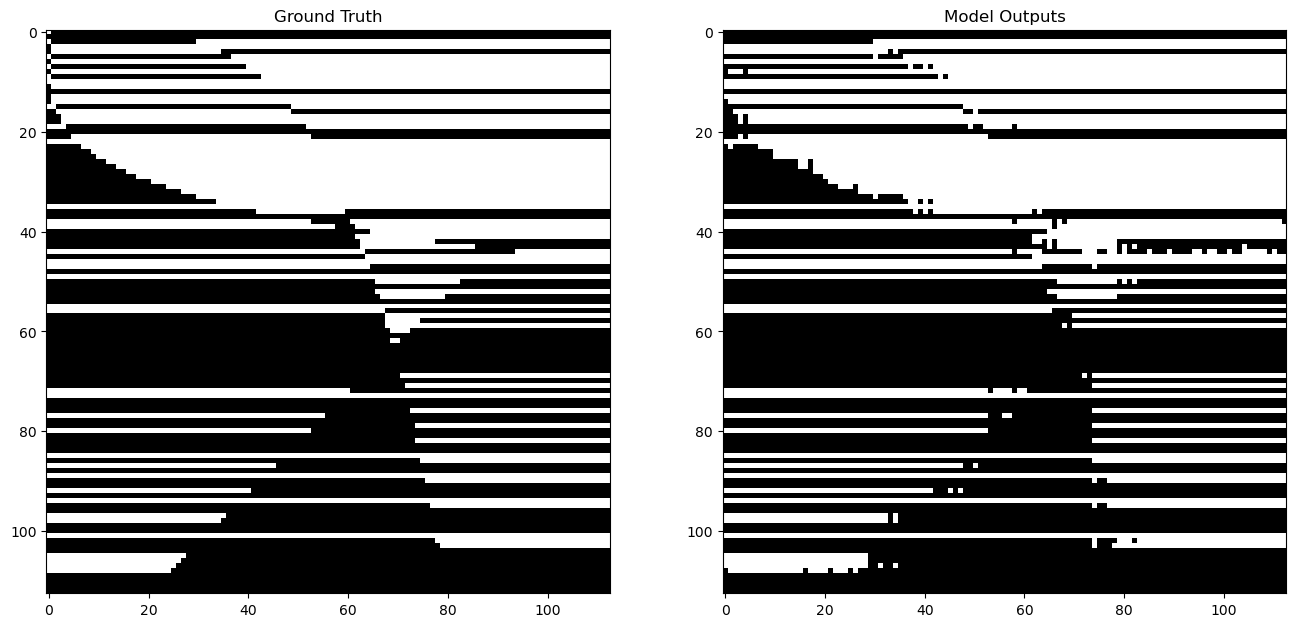

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].imshow(ground_truth_labels, cmap='gist_gray')
axes[0].set_title('Ground Truth')
axes[1].imshow(model_labels, cmap='gist_gray')
axes[1].set_title('Model Outputs')

In [14]:
plt.close()

## Tools

In [15]:
from transformer_lens import utils
from functools import partial

In [16]:

def imshow(
    tensor,
    xlabel="X",
    ylabel="Y",
    zlabel=None,
    xticks=None,
    yticks=None,
    c_midpoint=0.0,
    c_scale="RdBu",
    show=True,
    **kwargs
):
    tensor = utils.to_numpy(tensor)
    if "animation_frame" not in kwargs:
        assert len(tensor.shape) == 2
    else:
        assert len(tensor.shape) == 3
    xticks = xticks or range(tensor.shape[-1])
    yticks = yticks or range(tensor.shape[-2])
    xticks = [str(x) for x in xticks]
    yticks = [str(y) for y in yticks]
    if len(xticks) != len(set(xticks)):
        xticks = [f"{i}_{x}" for i, x in enumerate(xticks)]
    if len(yticks) != len(set(yticks)):
        yticks = [f"{i}_{y}" for i, y in enumerate(yticks)]
    labels = {"x": xlabel, "y": ylabel}
    if zlabel is not None:
        labels["color"] = zlabel
    fig = px.imshow(
        utils.to_numpy(tensor),
        x=xticks,
        y=yticks,
        labels=labels,
        color_continuous_midpoint=c_midpoint,
        color_continuous_scale=c_scale,
        **kwargs
    )
    if show:
        fig.show()
    else:
        return fig


# Analysis

Sorted with the benefit of hindsight :)

In [17]:
rerun_animation = False

In [18]:
class0_kwargs = dict(c="purple", alpha=0.3, s=2, label="class 0 (purple)")
class1_kwargs = dict(c="gold", alpha=0.3, s=2, label="class 1 (gold)")

## 1. Model mostly works if we fix the attention pattern


We run the model with a fixed attention pattern (set to mean) and recover most of the performance.

In [19]:
model.reset_hooks()
model.cfg.use_attn_result = True
sorted_inputs = torch.tensor(all_pairs)
clean_logits, clean_cache = model.run_with_cache(sorted_inputs)
assert np.all(model_labels == (clean_logits[:, -1, 0] < clean_logits[:, -1, 1]).reshape(p, p).numpy())
# Fix attn pattern
def patch_head(act, hook, pos=None, head=None):
    act[:, head, pos, :] = clean_cache[hook.name][:, head, pos, :].mean(dim=0, keepdim=False)
    return act

model.add_hook("blocks.0.attn.hook_pattern", partial(patch_head, pos=2, head=slice(None)))
fix_attn_logits, fix_attn_cache = model.run_with_cache(sorted_inputs)
fix_attn_labels = fix_attn_logits[:, -1, 0] < fix_attn_logits[:, -1, 1]
model.reset_hooks()

In [20]:
mean_pattern = clean_cache["blocks.0.attn.hook_pattern"][:, :, 2, :].mean(dim=0, keepdim=False)
print("Fixed to mean attn pattern:")
for i in range(8):
    print(f"Head {i}: {mean_pattern[i, :]}")

Fixed to mean attn pattern:
Head 0: tensor([0.8654, 0.0641, 0.0705])
Head 1: tensor([0.8789, 0.0535, 0.0676])
Head 2: tensor([0.2744, 0.6759, 0.0497])
Head 3: tensor([0.4816, 0.2326, 0.2858])
Head 4: tensor([0.6210, 0.2634, 0.1156])
Head 5: tensor([0.8623, 0.0536, 0.0841])
Head 6: tensor([0.4237, 0.2547, 0.3217])
Head 7: tensor([0.6474, 0.1436, 0.2090])


In [21]:
# fig, ax = plt.subplots(2, 2, figsize=(6, 6), constrained_layout=True)
# # cmap RdBlu
# ax[0, 0].imshow((clean_logits[:, -1, 0] - clean_logits[:, -1, 1]).reshape(113, 113).detach().numpy(), cmap='RdBu')
# ax[0, 0].set_title('Normal, Logit Diff')
# ax[0, 1].imshow((clean_logits[:, -1, 0] < clean_logits[:, -1, 1]).reshape(113, 113).detach().numpy(), cmap="gray")
# ax[0, 1].set_title('Normal, Labels')
# ax[1, 0].imshow((fix_attn_logits[:, -1, 0] - fix_attn_logits[:, -1, 1]).reshape(113, 113).detach().numpy(), cmap='RdBu')
# ax[1, 0].set_title('Fixed attn pattern, Logit Diff')
# ax[1, 1].imshow((fix_attn_logits[:, -1, 0] < fix_attn_logits[:, -1, 1]).reshape(113, 113).detach().numpy(), cmap="gray")
# ax[1, 1].set_title('Fixed attn pattern, Labels')
# plt.show()

Ignore the test/train part, we don't actually know which one is test & train

In [22]:
def performance(logits, truth=ground_truth_labels, test_only=False):
    # Convert to tensor if not tensor yet
    logits = torch.tensor(logits) if not isinstance(logits, torch.Tensor) else logits
    truth = torch.tensor(truth) if not isinstance(truth, torch.Tensor) else truth
    logits = logits.clone()
    truth = truth.clone().view(-1)
    if test_only:
        logits = logits[is_test]
        truth = truth[is_test]
    labels = logits[:, -1, 0] < logits[:, -1, 1]
    labels = labels.view(-1)
    percent_correct = (labels == truth).float().mean()
    accuracy_cas = 1-2*(1-percent_correct)
    print(f"{accuracy_cas:.2%} accuracy, {percent_correct:.1%} correct")

performance(clean_logits, test_only=False)
#performance(clean_logits, test_only=True)
performance(fix_attn_logits)
performance(fix_attn_logits, truth=model_labels)

97.27% accuracy, 98.6% correct
85.32% accuracy, 92.7% correct
85.73% accuracy, 92.9% correct


## 2. Task is already solved at resid_mid (basically)

All the important stuff happens in the extended embeddings (embedding + OV circuits), MLPs are just doing 2010-neural-net-style non-linear transformations

Explained variance ['53.3%', '32.1%', '5.4%', '1.1%', '0.7%', '0.5%', '0.5%', '0.4%', '0.4%', '0.3%'] ...
Explained variance ['54.7%', '29.4%', '4.8%', '1.1%', '0.9%', '0.8%', '0.5%', '0.5%', '0.4%', '0.4%'] ...
Explained variance ['53.3%', '32.1%', '5.4%', '1.1%', '0.7%', '0.5%', '0.5%', '0.4%', '0.4%', '0.3%'] ...
Explained variance ['54.7%', '29.4%', '4.8%', '1.1%', '0.9%', '0.8%', '0.5%', '0.5%', '0.4%', '0.4%'] ...
Explained variance ['53.3%', '32.1%', '5.4%', '1.1%', '0.7%', '0.5%', '0.5%', '0.4%', '0.4%', '0.3%'] ...
Explained variance ['54.7%', '29.4%', '4.8%', '1.1%', '0.9%', '0.8%', '0.5%', '0.5%', '0.4%', '0.4%'] ...


PCA(n_components=128)

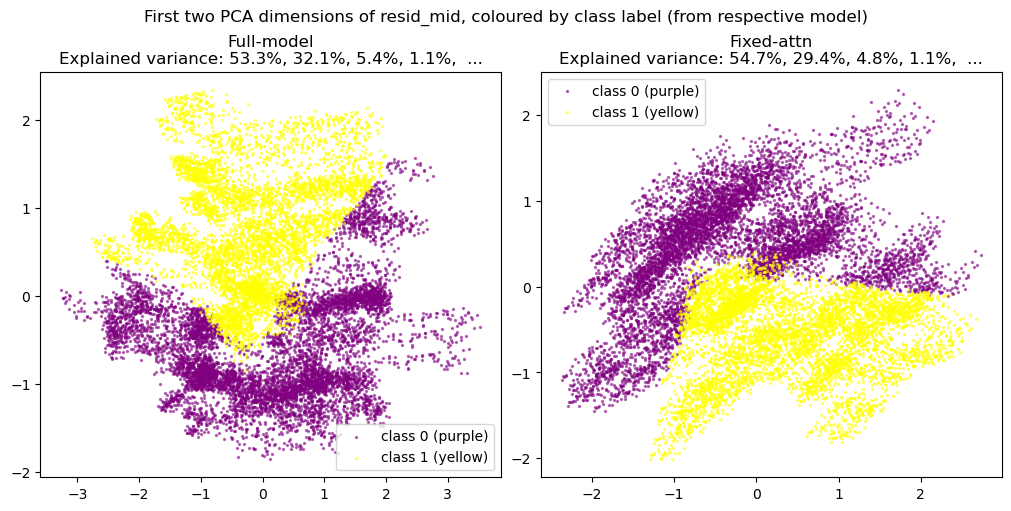

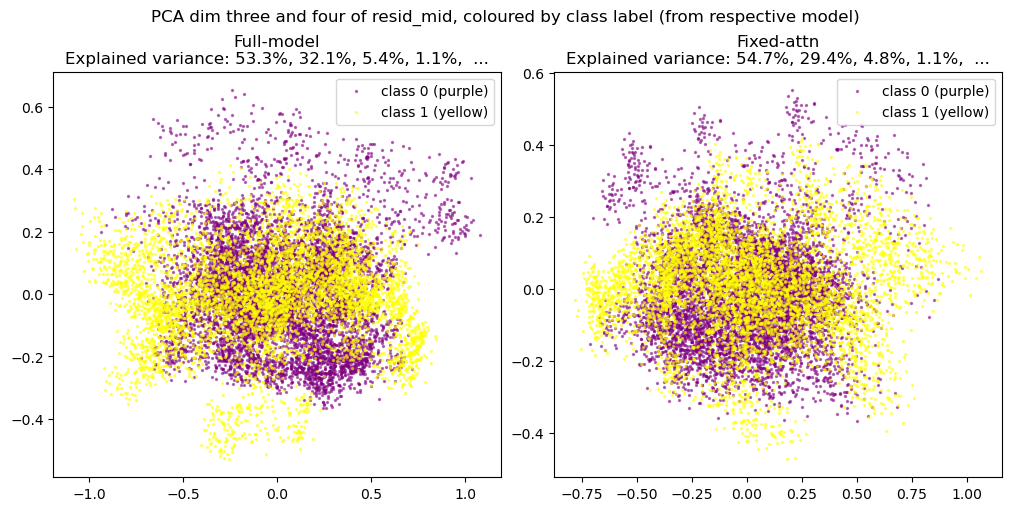

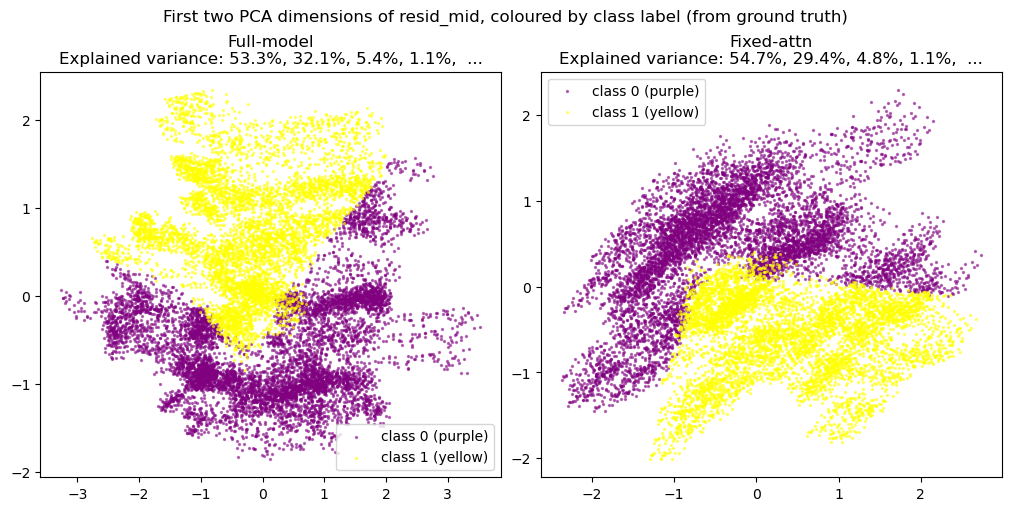

In [23]:
# PCA
from sklearn.decomposition import PCA

def pca_fit(acts, ax=None, title=None, labels=None, n=128, extradims=0):
    pca = PCA(n_components=n)
    result = pca.fit(acts)
    acts_2d = pca.transform(acts)
    if ax is not None:
        ax.scatter(acts_2d[labels==0, 0+extradims], acts_2d[labels==0, 1+extradims], c="purple", alpha=0.5, s=2, label="class 0 (purple)")
        ax.scatter(acts_2d[labels==1, 0+extradims], acts_2d[labels==1, 1+extradims], c="yellow", alpha=0.5, s=2, label="class 1 (yellow)")
        ax.legend()
        ax.set_title(title+"\nExplained variance: "+"".join([f"{r:.1%}, " for r in result.explained_variance_ratio_[:4]])+" ...")
    print("Explained variance", [f"{r:.1%}" for r in result.explained_variance_ratio_[:10]], "...")
    return pca

model_labels_flat = model_labels.reshape(-1)
fig, [ax1, ax2] = plt.subplots(figsize=(10, 5), ncols=2, nrows=1, constrained_layout=True)
fig.suptitle("First two PCA dimensions of resid_mid, coloured by class label (from respective model)")
pca_clean_mid = pca_fit(clean_cache["blocks.0.hook_resid_mid"][:,-1,:], ax1, "Full-model", model_labels_flat)
pca_fix_mid = pca_fit(fix_attn_cache["blocks.0.hook_resid_mid"][:,-1,:], ax2, "Fixed-attn", fix_attn_labels)

fig, [ax1, ax2] = plt.subplots(figsize=(10, 5), ncols=2, nrows=1, constrained_layout=True)
fig.suptitle("PCA dim three and four of resid_mid, coloured by class label (from respective model)")
pca_fit(clean_cache["blocks.0.hook_resid_mid"][:,-1,:], ax1, "Full-model", model_labels_flat, extradims=2)
pca_fit(fix_attn_cache["blocks.0.hook_resid_mid"][:,-1,:], ax2, "Fixed-attn", fix_attn_labels, extradims=2)

figG, [axG1, axG2] = plt.subplots(figsize=(10, 5), ncols=2, nrows=1, constrained_layout=True)
figG.suptitle("First two PCA dimensions of resid_mid, coloured by class label (from ground truth)")
pca_fit(clean_cache["blocks.0.hook_resid_mid"][:,-1,:], axG1, "Full-model", model_labels_flat)
pca_fit(fix_attn_cache["blocks.0.hook_resid_mid"][:,-1,:], axG2, "Fixed-attn", fix_attn_labels)


### Find directions corresponding to that separation

/tmp/ipykernel_78792/2990913502.py:61: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)

/tmp/ipykernel_78792/2990913502.py:5: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_78792/2990913502.py:8: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_78792/2990913502.py:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTe

tensor(0.9791)

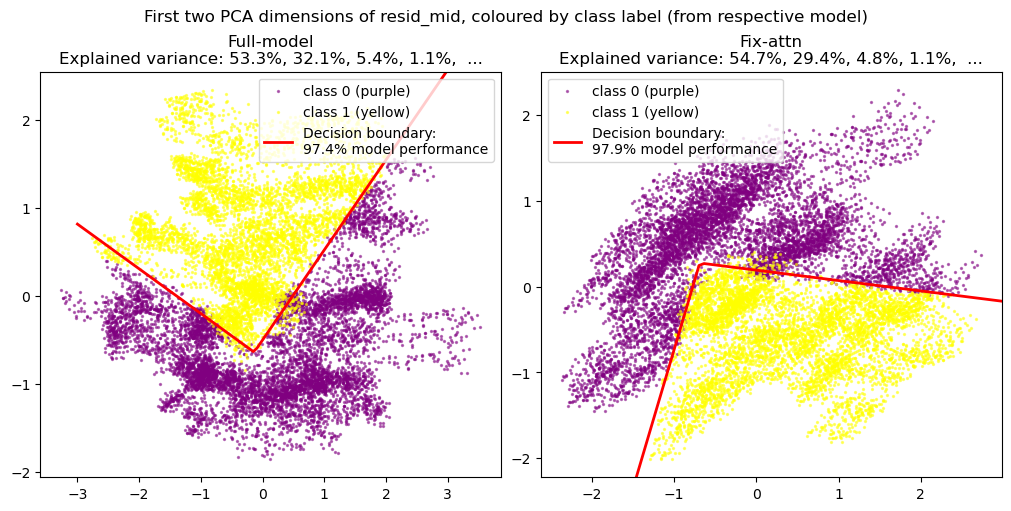

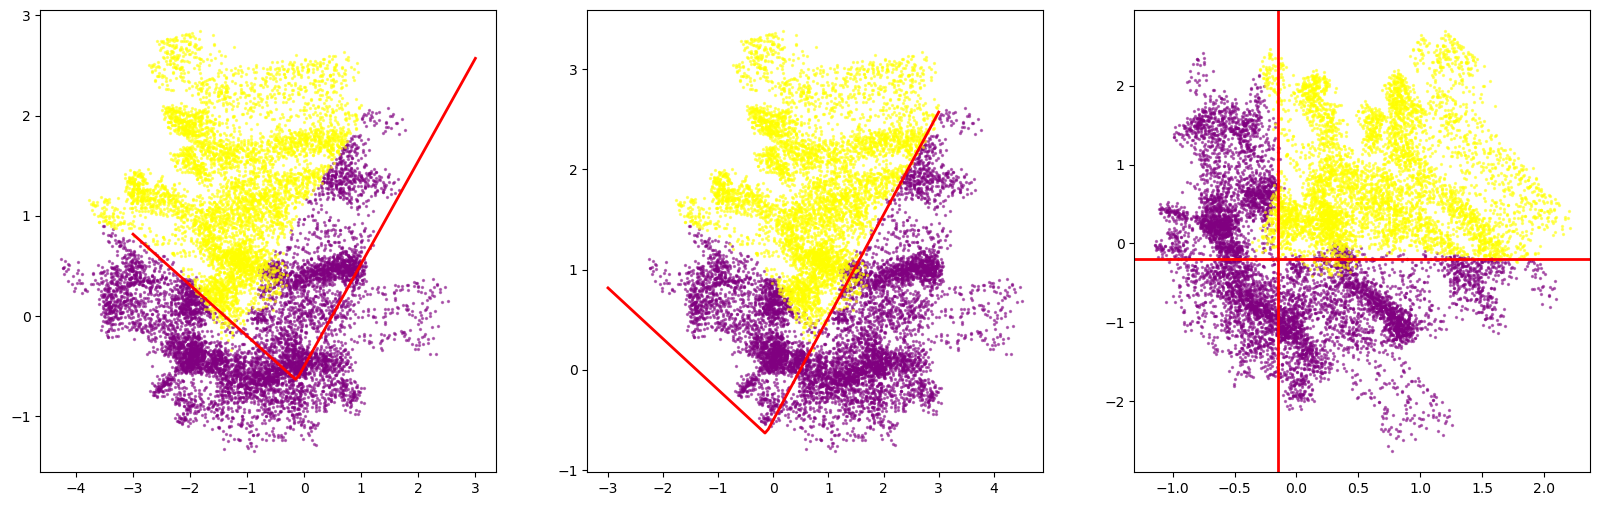

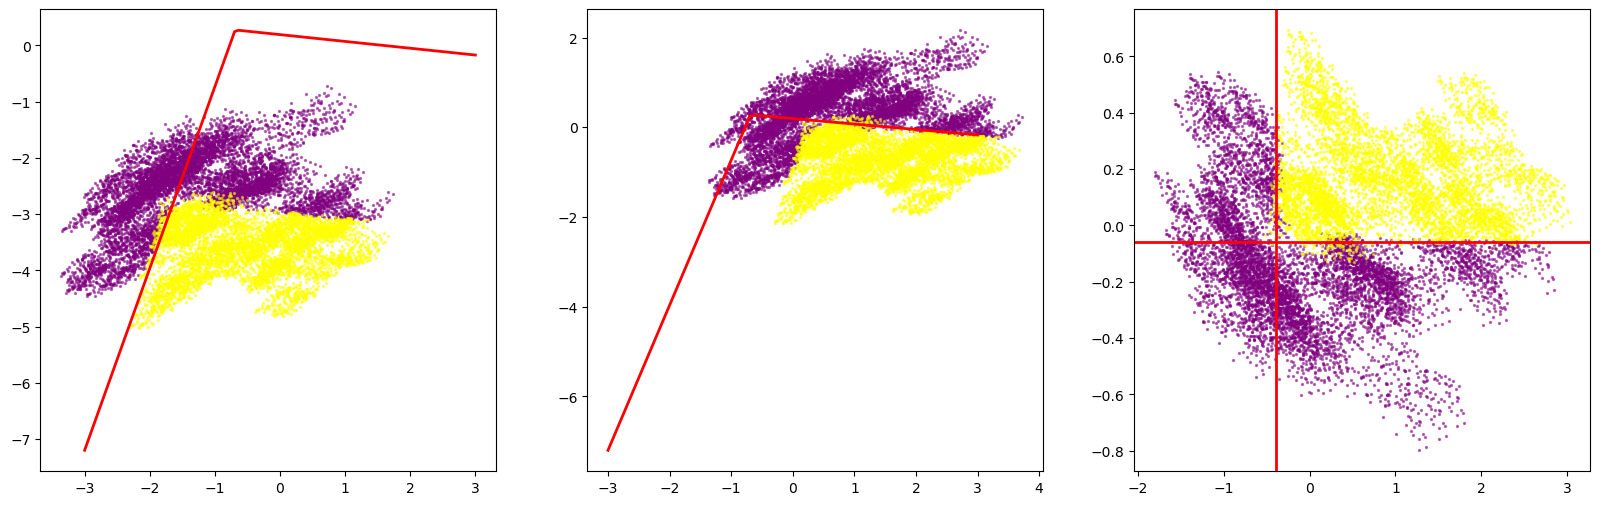

In [24]:
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar, minimize

def classify_with_boundaries(acts, vectors, thresh, labels):
    acts = torch.tensor(acts)
    mask_0 = (acts @ vectors)[:, 0] > thresh[0]
    mask_1 = (acts @ vectors)[:, 1] > thresh[1]
    labels = torch.tensor(labels).long().view(-1)
    return (mask_0 & mask_1 == labels).float().mean()

def fit_pca_directions(pca, acts, labels, ax=None, extra_axes=None, top_class=1):
    """
        Fit slpes to the two arms of the decision boundary. This is not a general function,
        in general these can be orientated weirdly, but for these two basis it is sufficient
        to check y > or < boundary. We define the two legs with slopes = dy/dx.
        If top_class==1 then class 1 (the AND) class is if y>boundary, else class 1 is y<boundary.
    """
    class1_above_boundary = 1 if top_class==1 else -1
    acts_proj = pca.transform(acts)
    if ax is not None:
        ax.scatter(acts_proj[labels==0, 0], acts_proj[labels==0, 1], c="purple", alpha=0.5, s=2, label="class 0 (purple)")
        ax.scatter(acts_proj[labels==1, 0], acts_proj[labels==1, 1], c="yellow", alpha=0.5, s=2, label="class 1 (yellow)")
        ax.legend()
    acts_proj = torch.tensor(acts_proj)
    labels = torch.tensor(labels).long().view(-1)
    def sigmoid(x):
        return 1 / (1 + torch.exp(-x))
    def loss_fn(args):
        corner_0, corner_1, slope_left, slope_right = args
        y_boundary = interp1d([-10, corner_0, 10], [-10*slope_left+corner_1, corner_1, corner_1+10*slope_right])(acts_proj[:, 0])
        y_boundary = torch.tensor(y_boundary)
        logit_class1 = class1_above_boundary * (acts_proj[:, 1] - y_boundary)
        loss = ((sigmoid(logit_class1) - labels)**10).mean()
        return loss
    
    # Initial guess, not sure if this is important to
    # make the left and right slopes match their names.
    x0 = [-0.15, -0.75, -0.72, 1.25] if class1_above_boundary==1 else [-0.9, 0.1, 2, -0.2]
    res = minimize(loss_fn, x0, bounds=[(-10, 10), (-10, 10), (-10, 10), (-10, 10)])
    corner_0, corner_1, slope_left, slope_right = res.x
    

    left_0 = corner_0 - 1
    left_1 = corner_1 - slope_left
    right_0 = corner_0 + 1
    right_1 = corner_1 + slope_right
    # For manipulations:
    directions_pcaspace = torch.zeros(3, acts.shape[1])
    directions_pcaspace[0, :2] = torch.tensor([left_0, left_1])
    directions_pcaspace[1, :2] = torch.tensor([corner_0, corner_1])
    directions_pcaspace[2, :2] = torch.tensor([right_0, right_1])
    directions_actspace = pca.inverse_transform(directions_pcaspace)

    transformation_matrix = np.array([[right_0 - corner_0, left_0 - corner_0], [right_1 - corner_1, left_1 - corner_1]])
    basis = np.linalg.inv(transformation_matrix) @ pca.components_[:2]
    
    corner = directions_actspace[1]
    thresh = corner @ basis.T
    direction_left = directions_actspace[0] - corner
    direction_right = directions_actspace[2] - corner
    direction_vectors = torch.tensor([direction_left, direction_right])
    if extra_axes is not None:
        ax2, ax3, ax4 = extra_axes
        corner_0, corner_1, slope_left, slope_right = res.x
        x = np.linspace(-3, 3, 100)
        y = interp1d([-10, corner_0, 10], [-10*slope_left+corner_1, corner_1, corner_1+10*slope_right])(x)
        ax2.plot(x, y, c="red", lw=2)
        ax3.plot(x, y, c="red", lw=2)
        if top_class == 0:
            thresh = thresh[::-1]
        ax4.axhline(thresh[0], c="red", lw=2)
        ax4.axvline(thresh[1], c="red", lw=2)
        if top_class == 0:
            thresh = thresh[::-1]
        manipulated_acts = acts + direction_left
        manipulated_pcaspace = pca.transform(manipulated_acts)
        ax2.scatter(manipulated_pcaspace[labels==0, 0], manipulated_pcaspace[labels==0, 1], c="purple", alpha=0.5, s=2, label="class 0 (purple)")
        ax2.scatter(manipulated_pcaspace[labels==1, 0], manipulated_pcaspace[labels==1, 1], c="yellow", alpha=0.5, s=2, label="class 1 (yellow)")
        manipulated_acts = acts + direction_right
        manipulated_pcaspace = pca.transform(manipulated_acts)
        ax3.scatter(manipulated_pcaspace[labels==0, 0], manipulated_pcaspace[labels==0, 1], c="purple", alpha=0.5, s=2, label="class 0 (purple)")
        ax3.scatter(manipulated_pcaspace[labels==1, 0], manipulated_pcaspace[labels==1, 1], c="yellow", alpha=0.5, s=2, label="class 1 (yellow)")
        # ax4: Classify us@ vector0, acts @ vector1ing the boundary
        basis = torch.tensor(basis).float()
        a = acts@basis.T
        ax4.scatter(a[labels==0, 0], a[labels==0, 1], c="purple", alpha=0.5, s=2, label="class 0 (purple)")
        ax4.scatter(a[labels==1, 0], a[labels==1, 1], c="yellow", alpha=0.5, s=2, label="class 1 (yellow)")
    if ax is not None:
        corner_0, corner_1, slope_left, slope_right = res.x
        x = np.linspace(-3, 3, 100)
        y = interp1d([-10, corner_0, 10], [-10*slope_left+corner_1, corner_1, corner_1+10*slope_right])(x)
        xlim, ylim = ax.get_xlim(), ax.get_ylim()
        precision = classify_with_boundaries(acts, basis.T, thresh, labels)
        ax.plot(x, y, c="red", lw=2, label=f"Decision boundary:\n{precision:.1%} model performance")
        ax.set_xlim(xlim); ax.set_ylim(ylim)
        ax.set_title(ax.get_title()+"\nExplained variance: "+"".join([f"{r:.1%}, " for r in pca.explained_variance_ratio_[:4]])+" ...")
        ax.legend()
    return basis.T, thresh, direction_vectors, [corner_0, corner_1, slope_left, slope_right]


fig, [ax1, ax2] = plt.subplots(figsize=(10, 5), ncols=2, nrows=1, constrained_layout=True)
ax1.set_title("Full-model")
ax2.set_title("Fix-attn")
fig.suptitle("First two PCA dimensions of resid_mid, coloured by class label (from respective model)")


fig2, extra_axes = plt.subplots(ncols=3, figsize=(20, 6))
basis_clean, thresh_clean, directions_clean, coords_lines_clean = fit_pca_directions(pca_clean_mid, clean_cache["blocks.0.hook_resid_mid"][:,-1,:], model_labels_flat, ax1, extra_axes=extra_axes);
classify_with_boundaries(clean_cache["blocks.0.hook_resid_mid"][:,-1,:], basis_clean, thresh_clean, model_labels_flat)

fig2, extra_axes = plt.subplots(ncols=3, figsize=(20, 6))
basis_fixattn, thresh_fixattn, directions_fixattn, coords_lines_fixattn = fit_pca_directions(pca_fix_mid, fix_attn_cache["blocks.0.hook_resid_mid"][:,-1,:], fix_attn_labels, ax2, extra_axes=extra_axes, top_class=0)
classify_with_boundaries(fix_attn_cache["blocks.0.hook_resid_mid"][:,-1,:], basis_fixattn, thresh_fixattn, fix_attn_labels)

In [25]:
class ActivationTransform:
    def __init__(self, pca, m, n):
        self.pca = pca
        self.Q = torch.tensor([[1, -m], [m, 1]])
        self.R = torch.tensor([[1, n], [-n, 1]])
        # Make matrices normal
        self.Q /= torch.norm(self.Q, dim=1, keepdim=True)
        self.R /= torch.norm(self.R, dim=1, keepdim=True)
    def transform(self, x):
        y = self.pca.transform(x)
        if isinstance(y, np.ndarray):
            y = torch.tensor(y)
        z = y.clone()
        z[:, 0] = (y[:, :2] @ self.Q.T)[:, 0]
        z[:, 1] = (y[:, :2] @ self.R.T)[:, 1]
        return z
    def inverse_transform(self, z):
        # Test if z is tensor
        if not isinstance(z, torch.Tensor):
            z = torch.tensor(z)
        # z_0 = y0 Q00 + y1 Q01
        # z_1 = y0 R10 + y1 R11
        # y0 = (z0 R11 - z1 Q01) / (Q00 R11 - Q01 R10)
        # y1 = (z1 Q00 - z0 R10) / (Q00 R11 - Q01 R10)
        y = z.clone()
        Q = self.Q
        R = self.R
        y[:, 0] = (z[:, 0] * R[1, 1] - z[:, 1] * Q[0, 1]) / (Q[0, 0] * R[1, 1] - Q[0, 1] * R[1, 0])
        y[:, 1] = (z[:, 1] * Q[0, 0] - z[:, 0] * R[1, 0]) / (Q[0, 0] * R[1, 1] - Q[0, 1] * R[1, 0])
        x = self.pca.inverse_transform(y)
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x)
        return x

x = fix_attn_cache["blocks.0.hook_resid_mid"][:,-1,:]
a = ActivationTransform(pca_fix_mid, 1/coords_lines_fixattn[2], coords_lines_fixattn[3])
assert torch.allclose(x.double(), a.inverse_transform(a.transform(x)), rtol=1e-5)

### Intervention: Add some sift and see what happens

In [26]:
def plot_pca_and_lines(pca, acts, labels, coords, ax=None):
    corner_0, corner_1, slope_left, slope_right = coords
    acts_2d = pca.transform(acts)
    # print(acts_2d.shape)
    # print(labels.shape)
    # print((labels==0).mean())
    ax.scatter(acts_2d[labels==0, 0], acts_2d[labels==0, 1], c="purple", alpha=0.5, s=2, label="class 0 (purple)")
    ax.scatter(acts_2d[labels==1, 0], acts_2d[labels==1, 1], c="yellow", alpha=0.5, s=2, label="class 1 (yellow)")
    left_0 = corner_0 - 10
    left_1 = corner_1 - 10*slope_left
    right_0 = corner_0 + 10
    right_1 = corner_1 + 10*slope_right
    ax.plot([left_0, corner_0, right_0], [left_1, corner_1, right_1], c="red", lw=2)

def model_of_mid(resid_mid):
    def hook_fn(activations, hook):
        activations[:, -1, :] = resid_mid
        return activations
    model.reset_hooks()
    logits = model.run_with_hooks(torch.zeros_like(sorted_inputs), fwd_hooks=[("blocks.0.hook_resid_mid", hook_fn)])[:, -1, :]
    labels = logits.argmax(dim=-1)
    return labels

import matplotlib.animation as animation


# Animate
for i in range(2):
    for j in range(2):
        pca = [pca_clean_mid, pca_fix_mid][i]
        acts = [clean_cache["blocks.0.hook_resid_mid"][:,-1,:], fix_attn_cache["blocks.0.hook_resid_mid"][:,-1,:]][i]
        #labels = [model_labels_flat, fix_attn_labels][i]
        coords = [coords_lines_clean, coords_lines_fixattn][i]
        direction = [directions_clean, directions_fixattn][i]
        basis = [basis_clean, basis_fixattn][i]
        thresh = [thresh_clean, thresh_fixattn][i]
        def animate(step, ax):
            print("\r step", step, end="")
            xlim, ylim = [-6, 6], [-6, 6]
            ax.clear()
            step_acts = acts + (step)*direction[j]
            labels = model_of_mid(step_acts)
            plot_pca_and_lines(pca, step_acts, labels, coords, ax=ax)
            ax.legend()
            ax.set_xlim(xlim); ax.set_ylim(ylim)
            ax.set_title(f"Moving activations along direction {j} by {step:.2f}")
            return ax
        if rerun_animation:
            fig, ax = plt.subplots(figsize=(4, 4), ncols=1, nrows=1, constrained_layout=True)
            anim = animation.FuncAnimation(fig, animate, frames=np.linspace(0, 3, 100), interval=100, fargs=(ax,))
            anim.save(f"shift_basis_{['clean', 'fixattn'][i]}_direction_{j}.mp4", writer="ffmpeg", fps=10)
            print("Saved as", f"pca_{['clean', 'fixattn'][i]}_{j}.mp4")

In [27]:
from IPython.display import HTML
HTML("""
<video width="400" height="400" controls>
    <source src="shift_basis_clean_direction_0.mp4" type="video/mp4">
</video>
<video width="400" height="400" controls>
    <source src="shift_basis_clean_direction_1.mp4" type="video/mp4">
</video>
<video width="400" height="400" controls>
    <source src="shift_basis_fixattn_direction_0.mp4" type="video/mp4">
</video>
<video width="400" height="400" controls>
    <source src="shift_basis_fixattn_direction_1.mp4" type="video/mp4">
</video>
""")

#### Actually random direction

In [28]:
def plot_pca_and_lines(pca, acts, labels, coords, ax=None):
    corner_0, corner_1, slope_left, slope_right = coords
    acts_2d = pca.transform(acts)
    # print(acts_2d.shape)
    # print(labels.shape)
    # print((labels==0).mean())
    ax.scatter(acts_2d[labels==0, 0], acts_2d[labels==0, 1], c="purple", alpha=0.5, s=2, label="class 0 (purple)")
    ax.scatter(acts_2d[labels==1, 0], acts_2d[labels==1, 1], c="yellow", alpha=0.5, s=2, label="class 1 (yellow)")
    left_0 = corner_0 - 10
    left_1 = corner_1 - 10*slope_left
    right_0 = corner_0 + 10
    right_1 = corner_1 + 10*slope_right
    ax.plot([left_0, corner_0, right_0], [left_1, corner_1, right_1], c="red", lw=2)

def model_of_mid(resid_mid):
    def hook_fn(activations, hook):
        activations[:, -1, :] = resid_mid
        return activations
    model.reset_hooks()
    logits = model.run_with_hooks(torch.zeros_like(sorted_inputs), fwd_hooks=[("blocks.0.hook_resid_mid", hook_fn)])[:, -1, :]
    labels = logits.argmax(dim=-1)
    return labels

import matplotlib.animation as animation


# Animate
for i in range(2):
    for j in range(2):
        pca = [pca_clean_mid, pca_fix_mid][i]
        acts = [clean_cache["blocks.0.hook_resid_mid"][:,-1,:], fix_attn_cache["blocks.0.hook_resid_mid"][:,-1,:]][i].clone()
        rand_direction = torch.randn(128)
        rand_direction /= rand_direction.norm()
        #labels = [model_labels_flat, fix_attn_labels][i]
        coords = [coords_lines_clean, coords_lines_fixattn][i]
        direction = [directions_clean, directions_fixattn][i]
        basis = [basis_clean, basis_fixattn][i]
        thresh = [thresh_clean, thresh_fixattn][i]
        def animate(step, ax):
            #global acts
            print("\r step", step, end="")
            xlim, ylim = [-3, 3], [-3, 3]
            ax.clear()
            step_acts = acts + (step)*rand_direction
            labels = model_of_mid(step_acts)
            plot_pca_and_lines(pca, step_acts, labels, coords, ax=ax)
            ax.legend()
            ax.set_xlim(xlim); ax.set_ylim(ylim)
            ax.set_title(f"Move random by {step:.2f}")
            #acts += 10*rand_direction
            return ax
        if rerun_animation:
            fig, ax = plt.subplots(figsize=(4, 4), ncols=1, nrows=1, constrained_layout=True)
            anim = animation.FuncAnimation(fig, animate, frames=np.linspace(0, 10, 100), interval=100, fargs=(ax,))
            anim.save(f"shift_basis_{['clean', 'fixattn'][i]}_random_direction_{j}.mp4", writer="ffmpeg", fps=10)


In [29]:
from IPython.display import HTML
HTML("""
<video width="400" height="400" controls>
    <source src="shift_basis_clean_random_direction_0.mp4" type="video/mp4">
</video>
<video width="400" height="400" controls>
    <source src="shift_basis_clean_random_direction_1.mp4" type="video/mp4">
</video>
<video width="400" height="400" controls>
    <source src="shift_basis_fixattn_random_direction_0.mp4" type="video/mp4">
</video>
<video width="400" height="400" controls>
    <source src="shift_basis_fixattn_random_direction_1.mp4" type="video/mp4">
</video>
""")

## 3. What the MLP does

Explained variance ['93.8%', '3.4%', '1.6%', '0.4%', '0.2%', '0.1%', '0.1%', '0.0%', '0.0%', '0.0%'] ...
Explained variance ['92.6%', '3.7%', '2.2%', '0.4%', '0.3%', '0.2%', '0.1%', '0.0%', '0.0%', '0.0%'] ...


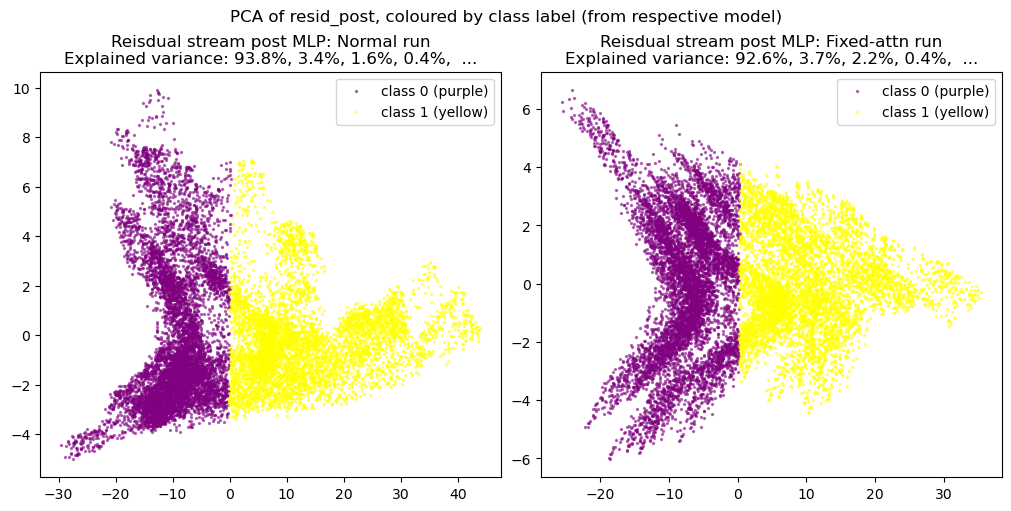

In [30]:
fig2, [ax3, ax4] = plt.subplots(figsize=(10, 5), ncols=2, nrows=1, constrained_layout=True)

fig2.suptitle("PCA of resid_post, coloured by class label (from respective model)")
pca_clean_post = pca_fit(clean_cache["blocks.0.hook_resid_post"][:,-1,:], ax3, "Reisdual stream post MLP: Normal run", model_labels_flat)
pca_fix_post = pca_fit(fix_attn_cache["blocks.0.hook_resid_post"][:,-1,:], ax4, "Reisdual stream post MLP: Fixed-attn run", fix_attn_labels)

### Animation by fraction

In [31]:
# Make a matplotlib animation
import matplotlib.animation as animation
from IPython.display import HTML


for i in range(2):
    cache = [clean_cache, fix_attn_cache][i]
    pca = [pca_clean_post, pca_fix_post][i]
    name = "mlp_animation"+["_clean", "_fixed-attention"][i]
    labels = [model_labels_flat, fix_attn_labels][i]
    labels = torch.tensor(labels).float()

    acts_post = cache["blocks.0.hook_resid_post"][:,-1,:]
    acts_post_2d = pca.transform(acts_post)

    tested_computation = False
    def fractional_progress(fraction):
        # Delete last line
        print(f"\rProgress: {fraction:.1%}", end="")
        global tested_computation
        acts_animation = cache["blocks.0.hook_resid_mid"][:,-1,:].clone()
        acts_animation += fraction*cache["blocks.0.hook_mlp_out"][:,-1,:]
        acts_animation_2d = pca.transform(acts_animation)
        if fraction == 1:
            assert torch.allclose(acts_animation, acts_post)
            tested_computation = True
        ax.clear()
        ax.scatter(acts_animation_2d[labels==0, 0], acts_animation_2d[labels==0, 1], c="purple", alpha=0.5, s=2, label="class 0 (purple)")
        ax.scatter(acts_animation_2d[labels==1, 0], acts_animation_2d[labels==1, 1], c="yellow", alpha=0.5, s=2, label="class 1 (yellow)")
        ax.set_title(f"Fraction of MLP progress: {fraction:.1%}")
        ax.set_xticks([])
        ax.set_yticks([])
        return ax

    if rerun_animation:
        print("Running animation", i)
        fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)
        fig.suptitle("2D PCA-space scatterplot of embeddings"+["(full model)", " (fixed attention)"][i])
        anim = animation.FuncAnimation(fig, fractional_progress, frames=np.geomspace(0.001, 1, 100), interval=100)
        anim.save(name+".mp4", dpi=300, fps=10)
        plt.close()
        print("\n")
        assert tested_computation, "Never tested if fraction=1 gives the same result as the full computation"

/tmp/ipykernel_78792/1192998484.py:11: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [32]:

# Show animation
HTML("""
<video width="640" height="480" controls>
    <source src="mlp_animation_clean.mp4" type="video/mp4">
</video>
<video width="640" height="480" controls>
    <source src="mlp_animation_fixed-attention.mp4" type="video/mp4">
</video>
""")

### Animation by neuron

In [33]:

from fancy_einsum import einsum
assert torch.all(clean_cache["blocks.0.hook_resid_post"] == clean_cache["blocks.0.hook_resid_mid"] + clean_cache["blocks.0.hook_mlp_out"])
assert torch.all(clean_cache["blocks.0.mlp.hook_pre"] == einsum("batch pos embed, embed hidden -> batch pos hidden", clean_cache["blocks.0.hook_resid_mid"], model.blocks[0].mlp.W_in) + model.blocks[0].mlp.b_in)
assert torch.all(torch.relu(clean_cache["blocks.0.mlp.hook_pre"]) == clean_cache["blocks.0.mlp.hook_post"])
assert torch.allclose(clean_cache["blocks.0.hook_mlp_out"], einsum("batch pos hidden, hidden embed -> batch pos embed", torch.relu(clean_cache["blocks.0.mlp.hook_pre"]), model.blocks[0].mlp.W_out) + model.blocks[0].mlp.b_out)



class MLP_PROGRESS:
    def __init__(self, ax, pca, cache, labels) -> None:
        self.Wout = model.blocks[0].mlp.W_out.detach()
        self.hookpost = cache["blocks.0.mlp.hook_post"].detach().clone()
        self.stack = cache["blocks.0.hook_resid_mid"].detach().clone()
        self.ax = ax
        self.pca = pca
        self.labels = labels
    
    def mlpout_by_neuron(self, index):
        return einsum("batch pos, embed -> batch pos embed", self.hookpost[:,:,index], self.Wout[index])

    def __call__(self, index):
        print("\r index", index, end="")
        if index == -2:
            pass
        elif index == -1:
            self.stack += model.blocks[0].mlp.b_out.detach()
            self.xlim = [-40, 40]#self.ax.get_xlim()
            self.ylim = [-20, 20]#self.ax.get_ylim()
        else:
            self.stack += self.mlpout_by_neuron(index)
            self.ax.set_xlim(self.xlim)
            self.ax.set_ylim(self.ylim)
        resid_2d = self.pca.transform(self.stack[:, -1, :])
        self.ax.clear()
        self.ax.scatter(resid_2d[self.labels==0, 0], resid_2d[self.labels==0, 1], c="purple", alpha=0.5, s=2, label="class 0 (purple)")
        self.ax.scatter(resid_2d[self.labels==1, 0], resid_2d[self.labels==1, 1], c="yellow", alpha=0.5, s=2, label="class 1 (yellow)")
        if index == -2:
            self.ax.set_title(f"resid mid")
        elif index == -1:
            self.ax.set_title(f"resid mid + MLP out bias")
        else:
            self.ax.set_title(f"resid mid + MLP up to neuron {index}")
        self.ax.set_xticks([])
        self.ax.set_yticks([])

model.reset_hooks()
sorted_inputs = torch.tensor(all_pairs)
from matplotlib import animation


for i in range(2):
    cache = [clean_cache, fix_attn_cache][i]
    pca = [pca_clean_post, pca_fix_post][i]
    name = "mlp_animation"+["_clean", "_fixed-attention"][i]
    labels = [model_labels_flat, fix_attn_labels][i]
    labels = torch.tensor(labels).float()
    
    if rerun_animation:
        fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)
        mlp_progress = MLP_PROGRESS(ax, pca, cache, labels)
        fig.suptitle("2D PCA-space")
        anim = animation.FuncAnimation(fig, mlp_progress, frames=[-2, *np.arange(-1, 1024, 1)], interval=100)
        anim.save(f"mlp_by_index_{name}.mp4", dpi=300)
        plt.close()
    # Show
    html = HTML(f"""
    <video width="640" height="480" controls>
        <source src="mlp_by_index_{name}.mp4" type="video/mp4">
    </video>
    """)
    display(html)


/tmp/ipykernel_78792/1775693961.py:56: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



## 4. Understanding the residual stream


### Table: Visualize the decision boundary directions

In [34]:
from fancy_einsum import einsum

mean_attn_clean = clean_cache["blocks.0.attn.hook_pattern"][:, :, 2, :].mean(dim=0, keepdim=False)
mean_attn_fix = fix_attn_cache["blocks.0.attn.hook_pattern"][:, :, 2, :].mean(dim=0, keepdim=False)

for i, mean_attn in enumerate([mean_attn_clean, mean_attn_fix]):
    W_E = model.W_E
    W_pos = model.W_pos
    W_EVO = einsum("vocab embed, one head embed hidden, one head hidden embed2, head pos -> pos vocab embed2", model.W_E, model.W_V, model.W_O, mean_attn)
    W_posVO = einsum("pos embed, one head embed hidden, one head hidden embed2, head pos -> pos embed2", model.W_pos, model.W_V, model.W_O, mean_attn)

    W_E_full = lambda A,B,C=113: W_E[C] + W_pos[2] + W_EVO[0, A] + W_EVO[1, B] + W_EVO[2, C] + W_posVO[0] + W_posVO[1] + W_posVO[2]
    W_const = W_E[113] + W_EVO[2, 113] + W_pos[2] + W_posVO[0] + W_posVO[1] + W_posVO[2]; print(W_const.shape)
    W_A = W_EVO[0]
    W_B = W_EVO[1]

    W_A0 = W_A @ basis_fixattn[:,0]
    W_A1 = W_A @ basis_fixattn[:,1]
    W_B0 = W_B @ basis_fixattn[:,0]
    W_B1 = W_B @ basis_fixattn[:,1]

    dfstack = torch.stack([W_A0, W_A1, W_B0, W_B1], dim=1)
    import pandas as pd
    df = pd.DataFrame(dfstack.T.detach().numpy())
    # Row labels
    df.index = ["W_A,α", "W_A,β", "W_B,α", "W_B,β"]
    # Color by value
    # :.1f
    styled_df = df.style.background_gradient(cmap='RdBu', axis=1).set_precision(2)
    styled_df.to_html(f"W_AW_B_{i}.html")
styled_df

/tmp/ipykernel_78792/2714347874.py:29: FutureWarning:

this method is deprecated in favour of `Styler.format(precision=..)`

/tmp/ipykernel_78792/2714347874.py:29: FutureWarning:

this method is deprecated in favour of `Styler.format(precision=..)`



torch.Size([128])
torch.Size([128])


### Image: Visualize directions and filters

torch.Size([128, 2]) (128, 128)
tensor([ 0.0577,  0.0838,  0.0054,  0.1737,  0.0777, -0.0438,  0.0141,  0.0453,
         0.0309, -0.1106, -0.0147, -0.0284, -0.0609, -0.1065, -0.0105,  0.0641,
        -0.0314, -0.0205, -0.0362,  0.0339,  0.0569,  0.0133,  0.0180, -0.0053,
        -0.0816, -0.0633, -0.0274, -0.0508, -0.0244,  0.1037,  0.1014,  0.0533,
         0.0566,  0.0351,  0.0052,  0.0276, -0.0281,  0.0551,  0.0555, -0.0734,
        -0.0838,  0.1392,  0.0173, -0.0082, -0.0004, -0.0641,  0.0327, -0.0082,
         0.1089,  0.0059, -0.0575,  0.1257, -0.1020, -0.0250,  0.0428, -0.0251,
         0.0524, -0.0548, -0.0225,  0.0036,  0.0679, -0.0752, -0.0027,  0.0491,
         0.1358, -0.0261, -0.0525, -0.0449,  0.1364,  0.0642,  0.0246,  0.0238,
        -0.0320, -0.0987, -0.0075,  0.0459,  0.1086, -0.0112, -0.0590, -0.0160,
        -0.0005, -0.0796,  0.0948,  0.0352, -0.0489,  0.0108,  0.0291, -0.0147,
         0.0517,  0.1143,  0.0224, -0.0065, -0.0292, -0.0512,  0.0854,  0.0822,
        

/tmp/ipykernel_78792/1300948177.py:35: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



torch.Size([128, 2]) (128, 128)
tensor([ 8.2112e-02,  1.3047e-01,  4.0236e-02,  2.4650e-01,  9.5643e-02,
        -7.2731e-02,  2.5648e-02,  5.3001e-02,  7.2850e-02, -1.5564e-01,
         1.3035e-04, -4.8792e-02, -7.8987e-02, -1.2314e-01,  1.1508e-03,
         1.0201e-01, -4.0020e-02, -1.0138e-02, -4.1296e-02,  6.4531e-02,
         9.9935e-02,  3.9797e-02,  3.5206e-02, -6.6104e-03, -1.0219e-01,
        -9.9952e-02, -3.2968e-02, -6.7704e-02, -2.7844e-02,  1.3951e-01,
         1.4335e-01,  5.6628e-02,  1.0324e-01,  2.8786e-02,  1.0602e-02,
         3.8308e-02, -5.9294e-02,  6.6159e-02,  7.7186e-02, -9.2555e-02,
        -1.2863e-01,  1.9811e-01,  1.4734e-02, -3.1234e-02,  3.7790e-04,
        -7.8228e-02,  2.3520e-02, -7.9871e-03,  1.5213e-01,  1.1717e-02,
        -6.3689e-02,  1.7509e-01, -1.3986e-01, -9.5738e-03,  4.4132e-02,
        -2.6877e-02,  8.8839e-02, -7.3072e-02, -5.2774e-02,  2.7936e-03,
         1.0118e-01, -1.2331e-01, -1.4604e-02,  5.9588e-02,  1.7611e-01,
        -6.5398e-03

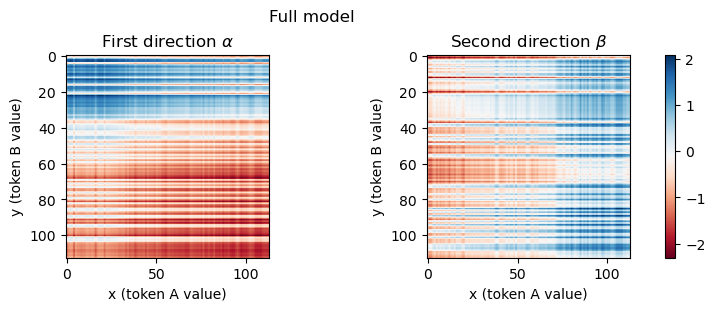

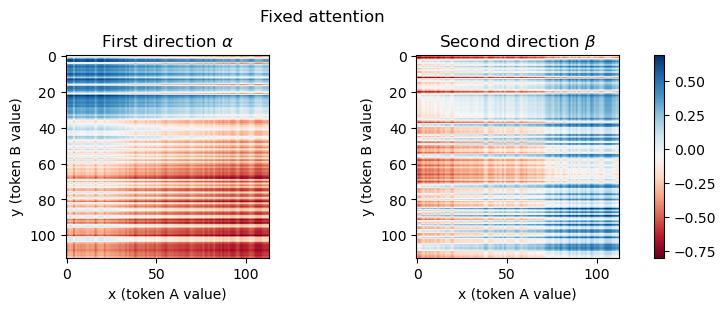

In [35]:
from fancy_einsum import einsum

mean_attn_clean = clean_cache["blocks.0.attn.hook_pattern"][:, :, 2, :].mean(dim=0, keepdim=False)
mean_attn_fix = fix_attn_cache["blocks.0.attn.hook_pattern"][:, :, 2, :].mean(dim=0, keepdim=False)

for i, mean_attn in enumerate([mean_attn_clean, mean_attn_fix]):
    vectors = [basis_clean, basis_fixattn][i]
    print(vectors.shape, pca_fix_mid.components_.shape)
    print(vectors[:,0] @ pca_fix_mid.components_)
    W_E = model.W_E
    W_pos = model.W_pos
    W_EVO = einsum("vocab embed, one head embed hidden, one head hidden embed2, head pos -> pos vocab embed2", model.W_E, model.W_V, model.W_O, mean_attn)
    W_posVO = einsum("pos embed, one head embed hidden, one head hidden embed2, head pos -> pos embed2", model.W_pos, model.W_V, model.W_O, mean_attn)

    W_E_full = lambda A,B,C=113: W_E[C] + W_pos[2] + W_EVO[0, A] + W_EVO[1, B] + W_EVO[2, C] + W_posVO[0] + W_posVO[1] + W_posVO[2]
    W_const = W_E[113] + W_EVO[2, 113] + W_pos[2] + W_posVO[0] + W_posVO[1] + W_posVO[2]; print(W_const.shape)
    W_A = W_EVO[0]
    W_B = W_EVO[1]

    fig, ax = plt.subplots(1, 2, figsize=(8, 3), constrained_layout=True)
    ax[0].imshow(((W_A[sorted_inputs[:, 0]]+W_B[sorted_inputs[:, 1]]+W_const).detach() @ vectors[:,0]).reshape(113, 113), cmap="RdBu")
    ax[0].set_title(r"First direction $\alpha$")
    ax[1].set_title(r"Second direction $\beta$")
    im = ax[1].imshow(((W_A[sorted_inputs[:, 0]]+W_B[sorted_inputs[:, 1]]+W_const).detach() @ vectors[:,1]).reshape(113, 113), cmap="RdBu")
    cbar = fig.colorbar(im, ax=ax.ravel().tolist())
    if i==0:
        fig.suptitle("Full model")
    else:
        fig.suptitle("Fixed attention")
    ax[0].set_xlabel("x (token A value)")
    ax[0].set_ylabel("y (token B value)")
    ax[1].set_xlabel("x (token A value)")
    ax[1].set_ylabel("y (token B value)")
    fig.savefig(f"class_directions_{i}.png", dpi=300)
    fig.show()

/tmp/ipykernel_78792/1219082188.py:20: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Text(0.5, 1.0, 'Labels (ground truth)')

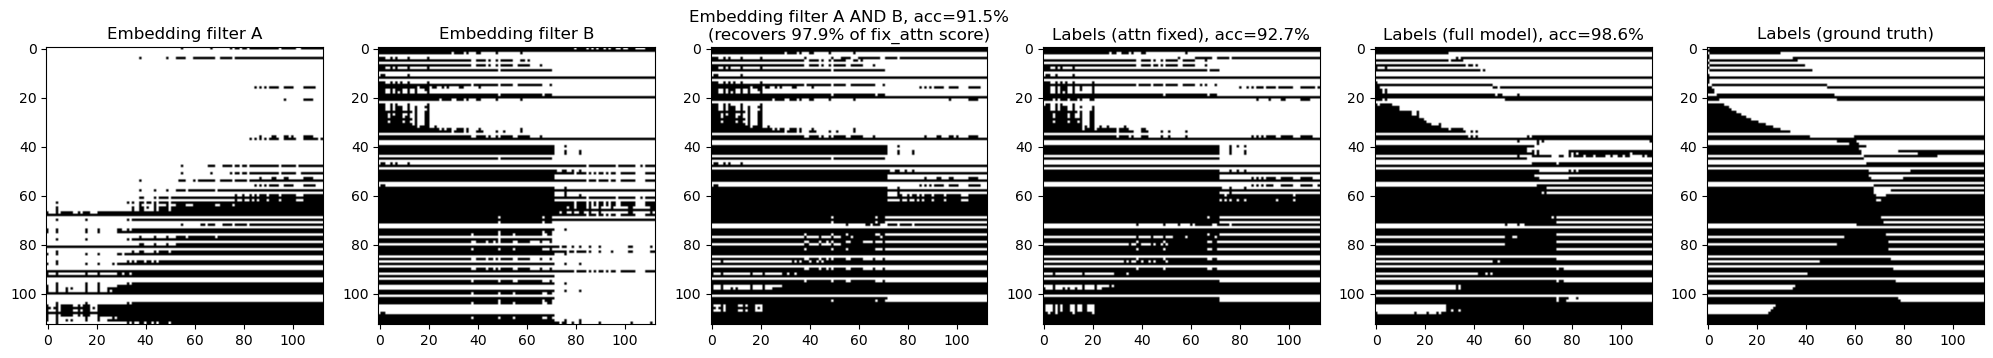

In [36]:
from fancy_einsum import einsum
mean_attn = clean_cache["blocks.0.attn.hook_pattern"][:, :, 2, :].mean(dim=0, keepdim=False)
W_E = model.W_E
W_pos = model.W_pos
W_EVO = einsum("vocab embed, one head embed hidden, one head hidden embed2, head pos -> pos vocab embed2", model.W_E, model.W_V, model.W_O, mean_attn)
W_posVO = einsum("pos embed, one head embed hidden, one head hidden embed2, head pos -> pos embed2", model.W_pos, model.W_V, model.W_O, mean_attn)

W_E_full = lambda A,B,C=113: W_E[C] + W_pos[2] + W_EVO[0, A] + W_EVO[1, B] + W_EVO[2, C] + W_posVO[0] + W_posVO[1] + W_posVO[2]
W_const = W_E[113] + W_EVO[2, 113] + W_pos[2] + W_posVO[0] + W_posVO[1] + W_posVO[2]
W_A = W_EVO[0]
W_B = W_EVO[1]

W_A_inv = torch.pinverse(W_A).detach().numpy()
W_B_inv = torch.pinverse(W_B).detach().numpy()


fig, axes = plt.subplots(1, 6, figsize=(25, 10))
resid_mid = (W_A[sorted_inputs[:, 0]]+W_B[sorted_inputs[:, 1]]+W_const).detach()

accuracy_score = lambda a,b: (torch.tensor(a).view(-1) == torch.tensor(b).view(-1)).float().mean()

class_1_A = (resid_mid @ basis_fixattn[:, 0]) > thresh_fixattn[0]
class_1_B = (resid_mid @ basis_fixattn[:, 1]) > thresh_fixattn[1]
class_1 = np.logical_and(class_1_A, class_1_B) # purple
axes[0].imshow(class_1_A.reshape(113, 113), cmap="gray")
axes[0].set_title("Embedding filter A")
axes[1].imshow(class_1_B.reshape(113, 113), cmap="gray")
axes[1].set_title("Embedding filter B")
axes[2].imshow(class_1.reshape(113, 113), cmap="gray")
axes[2].set_title(f"Embedding filter A AND B, acc={accuracy_score(ground_truth_labels, class_1):.1%}"+
                  f"\n(recovers {accuracy_score(class_1, fix_attn_labels):.1%} of fix_attn score)")
axes[3].imshow(fix_attn_labels.reshape(113, 113), cmap="gray")
axes[3].set_title(f"Labels (attn fixed), acc={accuracy_score(ground_truth_labels, fix_attn_labels):.1%}")
axes[4].imshow(model_labels.reshape(113, 113), cmap="gray")
axes[4].set_title(f"Labels (full model), acc={accuracy_score(ground_truth_labels, model_labels):.1%}")
axes[5].imshow(ground_truth_labels.reshape(113, 113), cmap="gray")
axes[5].set_title("Labels (ground truth)")

### Plot the difference between full and fixed attn by color

In [37]:
fix_attn_labels

tensor([False, False, False,  ..., False, False, False])

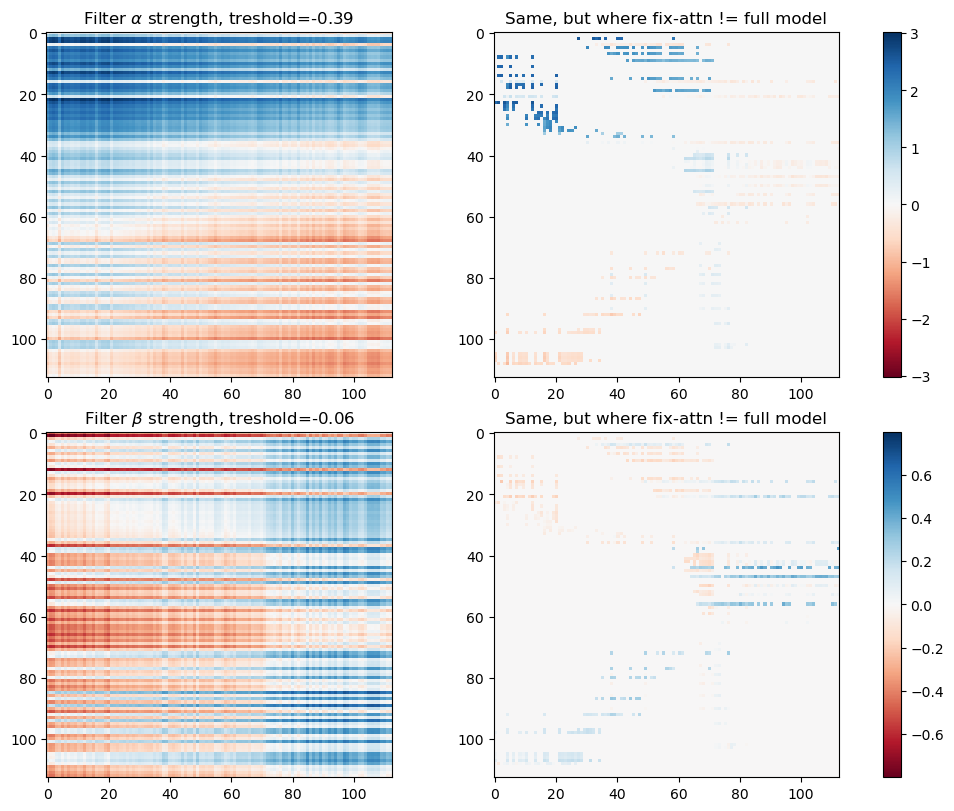

In [38]:
fig, A = plt.subplots(2, 2, figsize=(10, 8), constrained_layout=True)
accuracy_score = lambda a,b: (torch.tensor(a).view(-1) == torch.tensor(b).view(-1)).float().mean()
im_alpha = ((W_A[sorted_inputs[:, 0]]+W_B[sorted_inputs[:, 1]]+W_const).detach() @ vectors[:,0])
im_beta = ((W_A[sorted_inputs[:, 0]]+W_B[sorted_inputs[:, 1]]+W_const).detach() @ vectors[:,1])

for i, [im, axes] in enumerate(zip([im_alpha, im_beta], A)):
    sc = im.abs().max()
    #axes[1].imshow((im*torch.tensor(model_labels).view(-1).float()).reshape(113, 113), cmap="RdBu", vmin=-sc, vmax=sc)
    axes[0].imshow(im.reshape(113, 113), cmap="RdBu", vmin=-sc, vmax=sc)
    # alpha beta
    l = [r"$\alpha$", r"$\beta$"][i]
    axes[0].set_title(f"Filter {l} strength, treshold={thresh_fixattn[i]:.2f}")
    diff = (torch.tensor(model_labels).view(-1).float()!=fix_attn_labels)
    cbar = axes[1].imshow((im*diff.float()).reshape(113, 113), cmap="RdBu", vmin=-sc, vmax=sc)
    axes[1].set_title(f"Same, but where fix-attn != full model")
    # Add colorbar
    cbar = fig.colorbar(cbar, ax=axes.ravel().tolist())

# Attn animation

torch.Size([8, 3])
tensor([[ 1.9227, -0.8372, -0.8889],
        [ 1.9227, -0.4964, -0.8889],
        [ 1.9227, -0.4299, -0.8889],
        ...,
        [ 1.8952, -1.5335, -0.8889],
        [ 1.8952, -1.1011, -0.8889],
        [ 1.8952, -0.8647, -0.8889]])
tensor([[ 1.7854, -1.1800, -0.7819],
        [ 1.7854, -0.6144, -0.7819],
        [ 1.7854, -0.4445, -0.7819],
        ...,
        [ 2.1211, -1.3263, -0.7819],
        [ 2.1211, -1.1417, -0.7819],
        [ 2.1211, -0.8443, -0.7819]])
tensor([[-1.1826, -0.1238, -1.6937],
        [-1.1826,  0.5061, -1.6937],
        [-1.1826,  0.4752, -1.6937],
        ...,
        [ 0.9436,  1.7854, -1.6937],
        [ 0.9436,  1.7657, -1.6937],
        [ 0.9436,  2.0023, -1.6937]])
tensor([[ 0.2917, -0.4412, -0.0532],
        [ 0.2917, -0.3746, -0.0532],
        [ 0.2917, -0.0600, -0.0532],
        ...,
        [ 0.2867, -0.4141, -0.0532],
        [ 0.2867, -0.4592, -0.0532],
        [ 0.2867, -0.4462, -0.0532]])
tensor([[ 0.0158, -0.9334, -0.7581],


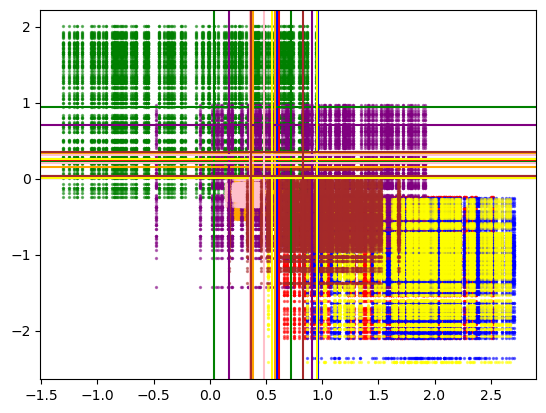

In [39]:
min_attn_scores = clean_cache["blocks.0.attn.hook_attn_scores"][:,:,-1,:].min(dim=0)[0]
max_attn_scores = clean_cache["blocks.0.attn.hook_attn_scores"][:,:,-1,:].max(dim=0)[0]
min_attn = clean_cache["blocks.0.attn.hook_pattern"][:,:,-1,:].min(dim=0)[0]
max_attn = clean_cache["blocks.0.attn.hook_pattern"][:,:,-1,:].max(dim=0)[0]
mean_attn_scores = clean_cache["blocks.0.attn.hook_attn_scores"][:,:,-1,:].mean(dim=0)
print(min_attn.shape)

for head in range(8):
    color = ["red", "blue", "green", "orange", "purple", "yellow", "pink", "brown"][head]
    data = clean_cache["blocks.0.attn.hook_attn_scores"][:,head,-1,:]
    print(data)
    plt.scatter(data[:, 0], data[:, 1], c=color, alpha=0.5, s=2)
    plt.axvline(min_attn[head, 0], c=color)
    plt.axvline(max_attn[head, 0], c=color)
    plt.axhline(min_attn[head, 1], c=color)
    plt.axhline(max_attn[head, 1], c=color)

In [40]:
# Numbers to check
acts_post = clean_cache["blocks.0.hook_resid_post"][:,-1,:]
acts_post_2d = pca_fix_post.transform(acts_post)

# Make a matplotlib animation
import matplotlib.animation as animation
from IPython.display import HTML


# Prep
model.reset_hooks()
sorted_inputs = torch.tensor(all_pairs)

def patch_head_scale(act, hook, pos=None, head=None, scale=0.5):
    if scale<=0.5:
        x = clean_cache[hook.name][:, head, pos, :].min(dim=0, keepdim=False)[0] + scale*2*(clean_cache[hook.name][:, head, pos, :].mean(dim=0, keepdim=False) - clean_cache[hook.name][:, head, pos, :].min(dim=0, keepdim=False)[0])
    else:
        x = clean_cache[hook.name][:, head, pos, :].mean(dim=0, keepdim=False) + (scale-0.5)*2*(clean_cache[hook.name][:, head, pos, :].max(dim=0, keepdim=False)[0] - clean_cache[hook.name][:, head, pos, :].mean(dim=0, keepdim=False))
    act[:, head, pos, :] = x
    return act



tested_computation = False
def scale_attn(fraction):
    print(fraction)
    model.reset_hooks()
    model.add_hook("blocks.0.attn.hook_pattern", partial(patch_head_scale, pos=2, head=slice(None), scale=fraction))        # Do this with einops
    corrupted_cache = model.run_with_cache(sorted_inputs)[1]
    resid_mid = corrupted_cache["blocks.0.hook_resid_mid"][:,-1,:]
    resid_mid_2d = pca_clean_mid.transform(resid_mid)
    ax.clear()
    ax.scatter(resid_mid_2d[model_labels_flat==0, 0], resid_mid_2d[model_labels_flat==0, 1], c="purple", alpha=0.5, s=2, label="class 0 (purple)")
    ax.scatter(resid_mid_2d[model_labels_flat==1, 0], resid_mid_2d[model_labels_flat==1, 1], c="yellow", alpha=0.5, s=2, label="class 1 (yellow)")
    if fraction <= 0.5:
        ax.set_title(f"Attn: min ..{fraction:.1%}.. mean")
    else:
        ax.set_title(f"Attn: mean ..{fraction:.1%}.. max")
    # No ticks
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

if rerun_animation:
    fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)
    fig.suptitle("2D PCA-space")
    anim = animation.FuncAnimation(fig, scale_attn, frames=np.linspace(0, 1, 201), interval=100)
    anim.save("attn_scaling.mp4")
# Display anim
HTML("""
<video width="640" height="480" controls>
    <source src="attn_scaling.mp4" type="video/mp4">
</video>
""")

In [41]:
# Numbers to check
acts_post = clean_cache["blocks.0.hook_resid_post"][:,-1,:]
acts_post_2d = pca_fix_post.transform(acts_post)

# Make a matplotlib animation
import matplotlib.animation as animation
from IPython.display import HTML


# Prep
model.reset_hooks()
sorted_inputs = torch.tensor(all_pairs)

def patch_head_to_mean(act, hook, pos=None, head=None, scale=0.5):
    orig =  act[:, head, pos, :]
    mean = orig.mean(dim=0, keepdim=True)
    out = mean + scale*(orig - mean)
    act[:, head, pos, :] = out
    return act


def scale_attn(fraction):
    print(fraction)
    model.reset_hooks()
    model.add_hook("blocks.0.attn.hook_pattern", partial(patch_head_to_mean, pos=2, head=slice(None), scale=fraction))        # Do this with einops
    corrupted_cache = model.run_with_cache(sorted_inputs)[1]
    resid_mid = corrupted_cache["blocks.0.hook_resid_mid"][:,-1,:]
    resid_mid_2d = pca_fix_mid.transform(resid_mid)
    ax.clear()
    ax.scatter(resid_mid_2d[model_labels_flat==0, 0], resid_mid_2d[model_labels_flat==0, 1], c="purple", alpha=0.5, s=2, label="class 0 (purple)")
    ax.scatter(resid_mid_2d[model_labels_flat==1, 0], resid_mid_2d[model_labels_flat==1, 1], c="yellow", alpha=0.5, s=2, label="class 1 (yellow)")
    ax.set_title(f"Attn: Mean ..{fraction:.1%}.. Full")
    # No ticks
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

if rerun_animation:
    fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)
    fig.suptitle("2D PCA-space")
    anim = animation.FuncAnimation(fig, scale_attn, frames=np.linspace(0, 1, 51), interval=100)
    anim.save("attn_scaling_full_fixpca.mp4")
# Display anim
HTML("""
<video width="640" height="480" controls>
    <source src="attn_scaling_full_fixpca.mp4" type="video/mp4">
</video>
""")

In [42]:

# Display anim
HTML("""
<video width="640" height="480" controls>
    <source src="attn_scaling_full.mp4" type="video/mp4">
</video>
""")

# Interventions
1. Both filters correspond to reaching a threshold for an embedding vector. If I slowly move points beyond the line in the PCA plot they will change color. --> Make an animation where  I add alpha*vector to all points showing how they move to the right. Then make the colors continuously update showing the full attn-fixed model-labels and hopefully they'll change. Do this in a a bunch of random directions (neg and pos), as well as the [0,1] and [1,0] directions. Predictions: Change color when crossing the line
2. Causal scrubbing applied on all 128 SVD directions: Prediction: Only dim 0 and 1 matter and can be resampled under AND condition

In what way am I testing
* Attn: None other than seems to not do sth
* Embedding: No I am not testing whether masks map to embedding, I am testing what the embedding means
* ReLU: Animation to show what it is doing, not how (that would work with the indiv neurons maybe)

Shown below:

1. 2 PCA dimensions explain model behaviour, in the linear (small perturbations) regime. (We can test with CaSc whether this holds for resampling-perturbations)
2. Shown that filters basically map onto lines in PCA dimensions; confused why those lines aren't exactly aligned with the lines I was expecting

## Demonstrating how those vectors are connected to the inputs

Select all points, that according to our mask, should lie on a certain line in the embedding space and see if that's true.

Randomly draw index pairs and check if color-imshow(index pairs) = similar for vec0 -- then show those points on embedding plot and as circles in both color plots.


/tmp/ipykernel_78792/3934242793.py:56: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

/tmp/ipykernel_78792/3934242793.py:73: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



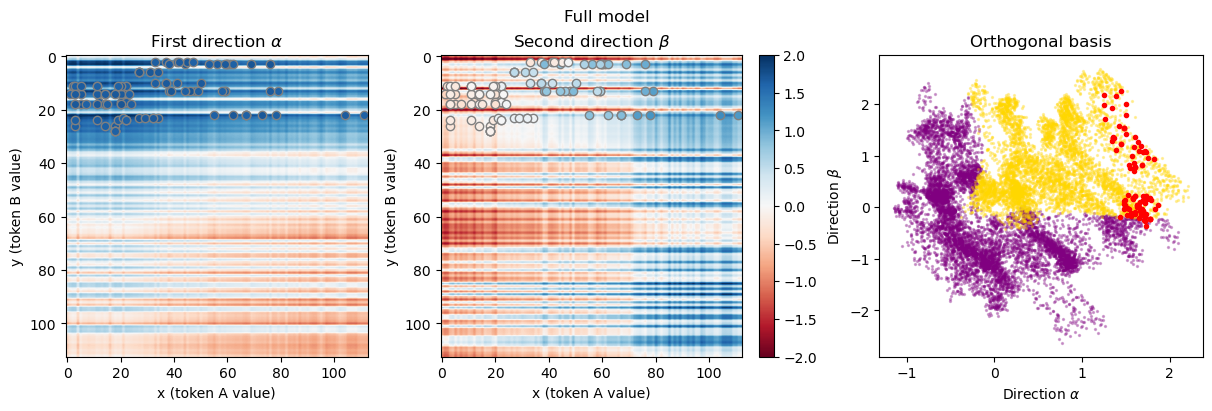

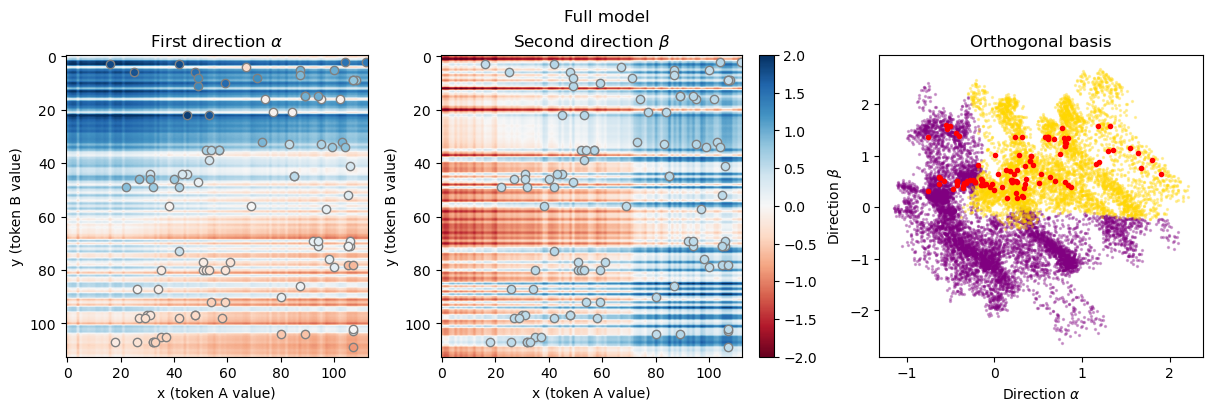

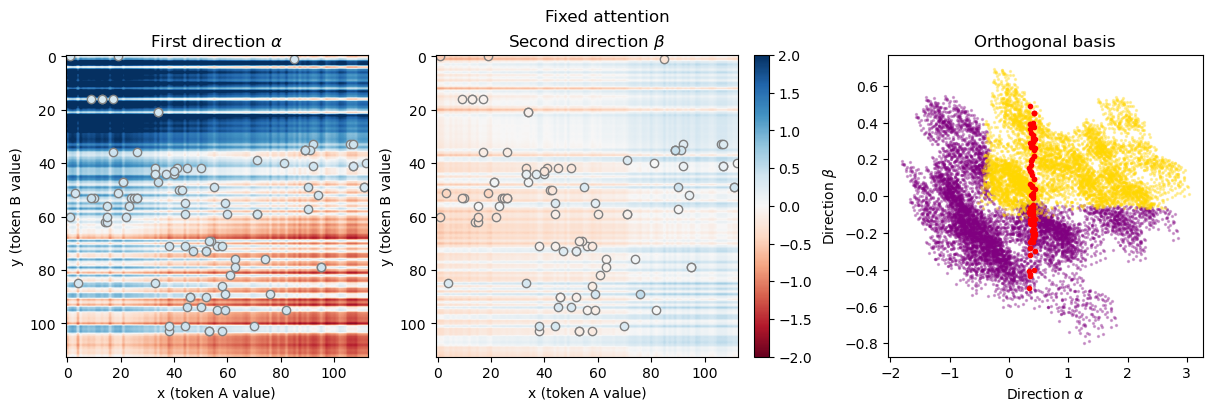

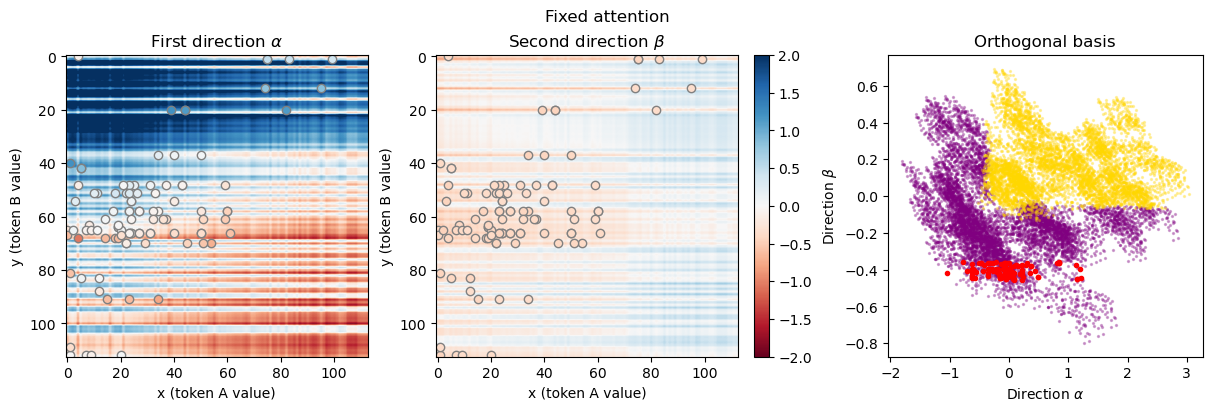

In [43]:
from fancy_einsum import einsum

# Something with clear colors, for the examples in doc
seed = 1
seed = 3
seed = 4
np.random.seed(seed)
mean_attn_clean = clean_cache["blocks.0.attn.hook_pattern"][:, :, 2, :].mean(dim=0, keepdim=False)
mean_attn_fix = fix_attn_cache["blocks.0.attn.hook_pattern"][:, :, 2, :].mean(dim=0, keepdim=False)

for i, mean_attn in enumerate([mean_attn_clean, mean_attn_fix]):
    for j in range(2):
        vectors = [basis_clean, basis_fixattn][i]
        W_E = model.W_E
        W_pos = model.W_pos
        W_EVO = einsum("vocab embed, one head embed hidden, one head hidden embed2, head pos -> pos vocab embed2", model.W_E, model.W_V, model.W_O, mean_attn)
        W_posVO = einsum("pos embed, one head embed hidden, one head hidden embed2, head pos -> pos embed2", model.W_pos, model.W_V, model.W_O, mean_attn)

        W_E_full = lambda A,B,C=113: W_E[C] + W_pos[2] + W_EVO[0, A] + W_EVO[1, B] + W_EVO[2, C] + W_posVO[0] + W_posVO[1] + W_posVO[2]
        W_const = W_E[113] + W_EVO[2, 113] + W_pos[2] + W_posVO[0] + W_posVO[1] + W_posVO[2]
        W_A = W_EVO[0]
        W_B = W_EVO[1]

        fig, ax = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
        im0 = ((W_A[sorted_inputs[:, 0]]+W_B[sorted_inputs[:, 1]]+W_const).detach() @ vectors[:,0])
        ax[0].imshow(im0.reshape(113, 113), cmap="RdBu", vmin=-2, vmax=2)
        ax[0].set_title(r"First direction $\alpha$")
        ax[1].set_title(r"Second direction $\beta$")
        im1 = ((W_A[sorted_inputs[:, 0]]+W_B[sorted_inputs[:, 1]]+W_const).detach() @ vectors[:,1])
        im = ax[1].imshow(im1.reshape(113, 113), cmap="RdBu", vmin=-2, vmax=2)
        cbar = fig.colorbar(im, ax=ax[1])
        if i==0:
            fig.suptitle("Full model")
        else:
            fig.suptitle("Fixed attention")
        ax[0].set_xlabel("x (token A value)")
        ax[0].set_ylabel("y (token B value)")
        ax[1].set_xlabel("x (token A value)")
        ax[1].set_ylabel("y (token B value)")

        selected_index = np.random.randint(0, 113**2)
        similar_indices = []
        im_data = [im0, im1][j]
        for _ in range(int(1e4)):
            idx = np.random.randint(0, 113**2)
            if (im_data[selected_index] - im_data[idx]).abs() < 0.05:
                similar_indices.append(idx)
            if len(similar_indices) == 100:
                break
    
        for idx in similar_indices:
            # Transform idx as view(113, 113) would
            x = idx % 113
            y = idx // 113
            # Cmap
            cmap = plt.cm.get_cmap("RdBu")
            # vmin
            vmin = -2
            # vmax
            vmax = 2
            # Color
            color = cmap(([im0, im1][0][idx].item() - vmin) / (vmax - vmin))
            ax[0].scatter(x, y, marker="o", color=color, edgecolor="grey")
            color = cmap(([im0, im1][1][idx].item() - vmin) / (vmax - vmin))
            ax[1].scatter(x, y, marker="o", color=color, edgecolor="grey")


        cache = [clean_cache, fix_attn_cache][i]
        resid_mid = cache["blocks.0.hook_resid_mid"][:, -1, :]
        basis = [basis_clean, basis_fixattn][i]
        resid_mid_2d = torch.stack([resid_mid @ basis[:,0], resid_mid @ basis[:,1]]).numpy().T
        label = [model_labels_flat, fix_attn_labels][i]
        label = torch.tensor(label).float()
        ax[2].scatter(resid_mid_2d[label==0, 0], resid_mid_2d[label==0, 1], **class0_kwargs)
        ax[2].scatter(resid_mid_2d[label==1, 0], resid_mid_2d[label==1, 1], **class1_kwargs)
        ax[2].scatter(resid_mid_2d[similar_indices, 0], resid_mid_2d[similar_indices, 1], marker=".", color="red")
        ax[2].set_xlabel(r"Direction $\alpha$")
        ax[2].set_ylabel(r"Direction $\beta$")
        ax[2].set_title("Orthogonal basis")


## Causal Scrubbing

For every coordinate, my condition is vec0 AND vec1. So as long as I exchange the PCA-dim with any other vector should be same result.

Test1: Swap the 126 unimportant dims
Test2: Swap all dims according to hypothesis

In [44]:
def model_of_mid(resid_mid):
    def hook_fn(activations, hook):
        activations[:, -1, :] = resid_mid
        return activations
    model.reset_hooks()
    logits = model.run_with_hooks(torch.zeros_like(sorted_inputs), fwd_hooks=[("blocks.0.hook_resid_mid", hook_fn)])[:, -1, :]
    labels = logits.argmax(dim=-1)
    return labels

In [45]:
np.random.seed(0)

baseline = (model_labels_flat == model_of_mid(acts).detach().numpy()).mean()
print(f"Baseline (Fix attn vs full model labels): {baseline:.1%}")

pca = PCA(n_components=128)
acts = fix_attn_cache["blocks.0.hook_resid_mid"][:,-1,:].clone()
pca.fit(acts)

AT = ActivationTransform(pca, 1/coords_lines_fixattn[2], coords_lines_fixattn[3])
acts_transformed = AT.transform(acts)

assert torch.allclose(acts.double(), AT.inverse_transform(acts_transformed))

class_1_A = filter_alpha = (acts @ basis_fixattn[:, 0]) > thresh_fixattn[0]
class_1_B = filter_beta = (acts @ basis_fixattn[:, 1]) > thresh_fixattn[1]
class_1 = np.logical_and(class_1_A, class_1_B) # purple
assert torch.all(~class_1 | ~class_1_A == ~class_1)
print(f"Goal (Filters vs full model labels) {((torch.tensor(model_labels_flat) == class_1.float()).float().mean()):.1%}")


def custom_shuffle(x):
    N = len(x)
    order = torch.randperm(N)
    return x[order]


acts_transformed = AT.transform(acts)
acts_transformed[:, 2:] = custom_shuffle(acts_transformed[:, 2:])
print(f"[1] {(model_labels_flat == model_of_mid((AT.inverse_transform(acts_transformed))).detach().numpy()).mean():.1%}")

acts_transformed = AT.transform(acts)
acts_transformed[:, 3:] = custom_shuffle(acts_transformed[:, 3:])
print(f"[1*] {(model_labels_flat == model_of_mid((AT.inverse_transform(acts_transformed))).detach().numpy()).mean():.1%}")

print("--- From now on always shuffle dims 2-127 ---")


# Swaps allowed by indiv result being the same. Imagine matrix
# TT TF
# FT FF
# Simple swap: Swap all leftT with leftT, all rightT with rightT, all leftF with leftF, all rightF with rightF
acts_transformed = AT.transform(acts)
acts_transformed[:, 2:] = custom_shuffle(acts_transformed[:, 2:])

acts_transformed[class_1_A, 0] = custom_shuffle(acts_transformed[class_1_A, 0])
acts_transformed[~class_1_A, 0] = custom_shuffle(acts_transformed[~class_1_A, 0])
acts_transformed[class_1_B, 1] = custom_shuffle(acts_transformed[class_1_B, 1])
acts_transformed[~class_1_B, 1] = custom_shuffle(acts_transformed[~class_1_B, 1])
print(f"[1+2]: {(model_labels_flat == model_of_mid((AT.inverse_transform(acts_transformed))).detach().numpy()).mean():.1%}")

# One extra swap we can do is
# Swap 2nd column T*F* with F*F* cause false
# filter_alpha and ~filter_beta with ~filter_alpha and ~filter_beta
acts_transformed = AT.transform(acts)
acts_transformed[:, 2:] = custom_shuffle(acts_transformed[:, 2:])

mask = (filter_alpha & ~filter_beta) | (~filter_alpha & ~filter_beta)
acts_transformed[mask, 0] = custom_shuffle(acts_transformed[mask, 0])
print(f"[1+3a]: {(model_labels_flat == model_of_mid((AT.inverse_transform(acts_transformed))).detach().numpy()).mean():.1%}")

# One extra swap we can do is
# Swap 2nd row F*T* wit F*F* cause AND-gate is False anyway
# ~filter_alpha and ~beta with ~filter_alpha and beta
acts_transformed = AT.transform(acts)
acts_transformed[:, 2:] = custom_shuffle(acts_transformed[:, 2:])

mask = (~filter_alpha & ~filter_beta) | (~filter_alpha & filter_beta)
acts_transformed[mask, 1] = custom_shuffle(acts_transformed[mask, 1])
print(f"[1+3b]: {(model_labels_flat == model_of_mid((AT.inverse_transform(acts_transformed))).detach().numpy()).mean():.1%}")


# All swaps, can't do both of the last two at once!

acts_transformed = AT.transform(acts)
acts_transformed[:, 2:] = custom_shuffle(acts_transformed[:, 2:])

acts_transformed[class_1_A, 0] = custom_shuffle(acts_transformed[class_1_A, 0])
acts_transformed[~class_1_A, 0] = custom_shuffle(acts_transformed[~class_1_A, 0])
acts_transformed[class_1_B, 1] = custom_shuffle(acts_transformed[class_1_B, 1])
acts_transformed[~class_1_B, 1] = custom_shuffle(acts_transformed[~class_1_B, 1])

mask = ~filter_beta
acts_transformed[mask, 0] = custom_shuffle(acts_transformed[mask, 0])

#mask = ~filter_alpha
#acts_transformed[mask, 1] = custom_shuffle(acts_transformed[mask, 1])

print(f"[1+2+3a]: {(model_labels_flat == model_of_mid((AT.inverse_transform(acts_transformed))).detach().numpy()).mean():.1%}")

# All swaps, can't do both of the last two at once!

acts_transformed = AT.transform(acts)
acts_transformed[:, 2:] = custom_shuffle(acts_transformed[:, 2:])

acts_transformed[class_1_A, 0] = custom_shuffle(acts_transformed[class_1_A, 0])
acts_transformed[~class_1_A, 0] = custom_shuffle(acts_transformed[~class_1_A, 0])
acts_transformed[class_1_B, 1] = custom_shuffle(acts_transformed[class_1_B, 1])
acts_transformed[~class_1_B, 1] = custom_shuffle(acts_transformed[~class_1_B, 1])

#mask = ~filter_beta
#acts_transformed[mask, 0] = custom_shuffle(acts_transformed[mask, 0])

mask = ~filter_alpha
acts_transformed[mask, 1] = custom_shuffle(acts_transformed[mask, 1])

print(f"[1+2+3b] {(model_labels_flat == model_of_mid((AT.inverse_transform(acts_transformed))).detach().numpy()).mean():.1%}")

# All swaps, can't do both of the last two at once!

acts_transformed = AT.transform(acts)
acts_transformed[:, 2:] = custom_shuffle(acts_transformed[:, 2:])

acts_transformed[class_1_A, 0] = custom_shuffle(acts_transformed[class_1_A, 0])
acts_transformed[~class_1_A, 0] = custom_shuffle(acts_transformed[~class_1_A, 0])
acts_transformed[class_1_B, 1] = custom_shuffle(acts_transformed[class_1_B, 1])
acts_transformed[~class_1_B, 1] = custom_shuffle(acts_transformed[~class_1_B, 1])

mask = ~filter_beta
acts_transformed[mask, 0] = custom_shuffle(acts_transformed[mask, 0])

filter_alpha_new = (AT.inverse_transform(acts_transformed).float() @ basis_fixattn[:, 0]) > thresh_fixattn[0]

mask = ~filter_alpha_new
acts_transformed[mask, 1] = custom_shuffle(acts_transformed[mask, 1])

print(f"[1+2+3a+3b]: {(model_labels_flat == model_of_mid((AT.inverse_transform(acts_transformed))).detach().numpy()).mean():.1%}")

Baseline (Fix attn vs full model labels): 92.9%
Goal (Filters vs full model labels) 91.6%
[1] 91.2%
[1*] 92.6%
--- From now on always shuffle dims 2-127 ---
[1+2]: 88.8%
[1+3a]: 91.0%
[1+3b]: 91.0%
[1+2+3a]: 88.9%
[1+2+3b] 89.0%
[1+2+3a+3b]: 88.9%


In [46]:
np.random.seed(0)

baseline = (model_labels_flat == model_of_mid(acts).detach().numpy()).mean()
print(f"Baseline (Fix attn vs full model labels): {baseline:.1%}")

pca = PCA(n_components=128)
acts = clean_cache["blocks.0.hook_resid_mid"][:,-1,:].clone()
pca.fit(acts)

AT = ActivationTransform(pca, 1/coords_lines_clean[2], coords_lines_clean[3])
acts_transformed = AT.transform(acts)

assert torch.allclose(acts.double(), AT.inverse_transform(acts_transformed))

class_1_A = filter_alpha = (acts @ basis_clean[:, 0]) > thresh_clean[0]
class_1_B = filter_beta = (acts @ basis_clean[:, 1]) > thresh_clean[1]
class_1 = np.logical_and(class_1_A, class_1_B) # purple
assert torch.all(~class_1 | ~class_1_A == ~class_1)
print(f"Goal (Filters vs full model labels) {((torch.tensor(model_labels_flat) == class_1.float()).float().mean()):.1%}")


def custom_shuffle(x):
    N = len(x)
    order = torch.randperm(N)
    return x[order]


acts_transformed = AT.transform(acts)
acts_transformed[:, 2:] = custom_shuffle(acts_transformed[:, 2:])
print(f"[1] {(model_labels_flat == model_of_mid((AT.inverse_transform(acts_transformed))).detach().numpy()).mean():.1%}")

acts_transformed = AT.transform(acts)
acts_transformed[:, 3:] = custom_shuffle(acts_transformed[:, 3:])
print(f"[1*] {(model_labels_flat == model_of_mid((AT.inverse_transform(acts_transformed))).detach().numpy()).mean():.1%}")

print("--- From now on always shuffle dims 2-127 ---")


# Swaps allowed by indiv result being the same. Imagine matrix
# TT TF
# FT FF
# Simple swap: Swap all leftT with leftT, all rightT with rightT, all leftF with leftF, all rightF with rightF
acts_transformed = AT.transform(acts)
acts_transformed[:, 2:] = custom_shuffle(acts_transformed[:, 2:])

acts_transformed[class_1_A, 0] = custom_shuffle(acts_transformed[class_1_A, 0])
acts_transformed[~class_1_A, 0] = custom_shuffle(acts_transformed[~class_1_A, 0])
acts_transformed[class_1_B, 1] = custom_shuffle(acts_transformed[class_1_B, 1])
acts_transformed[~class_1_B, 1] = custom_shuffle(acts_transformed[~class_1_B, 1])
print(f"[1+2]: {(model_labels_flat == model_of_mid((AT.inverse_transform(acts_transformed))).detach().numpy()).mean():.1%}")

# One extra swap we can do is
# Swap 2nd column T*F* with F*F* cause false
# filter_alpha and ~filter_beta with ~filter_alpha and ~filter_beta
acts_transformed = AT.transform(acts)
acts_transformed[:, 2:] = custom_shuffle(acts_transformed[:, 2:])

mask = (filter_alpha & ~filter_beta) | (~filter_alpha & ~filter_beta)
acts_transformed[mask, 0] = custom_shuffle(acts_transformed[mask, 0])
print(f"[1+3a]: {(model_labels_flat == model_of_mid((AT.inverse_transform(acts_transformed))).detach().numpy()).mean():.1%}")

# One extra swap we can do is
# Swap 2nd row F*T* wit F*F* cause AND-gate is False anyway
# ~filter_alpha and ~beta with ~filter_alpha and beta
acts_transformed = AT.transform(acts)
acts_transformed[:, 2:] = custom_shuffle(acts_transformed[:, 2:])

mask = (~filter_alpha & ~filter_beta) | (~filter_alpha & filter_beta)
acts_transformed[mask, 1] = custom_shuffle(acts_transformed[mask, 1])
print(f"[1+3b]: {(model_labels_flat == model_of_mid((AT.inverse_transform(acts_transformed))).detach().numpy()).mean():.1%}")


# All swaps, can't do both of the last two at once!

acts_transformed = AT.transform(acts)
acts_transformed[:, 2:] = custom_shuffle(acts_transformed[:, 2:])

acts_transformed[class_1_A, 0] = custom_shuffle(acts_transformed[class_1_A, 0])
acts_transformed[~class_1_A, 0] = custom_shuffle(acts_transformed[~class_1_A, 0])
acts_transformed[class_1_B, 1] = custom_shuffle(acts_transformed[class_1_B, 1])
acts_transformed[~class_1_B, 1] = custom_shuffle(acts_transformed[~class_1_B, 1])

mask = ~filter_beta
acts_transformed[mask, 0] = custom_shuffle(acts_transformed[mask, 0])

#mask = ~filter_alpha
#acts_transformed[mask, 1] = custom_shuffle(acts_transformed[mask, 1])

print(f"[1+2+3a]: {(model_labels_flat == model_of_mid((AT.inverse_transform(acts_transformed))).detach().numpy()).mean():.1%}")

# All swaps, can't do both of the last two at once!

acts_transformed = AT.transform(acts)
acts_transformed[:, 2:] = custom_shuffle(acts_transformed[:, 2:])

acts_transformed[class_1_A, 0] = custom_shuffle(acts_transformed[class_1_A, 0])
acts_transformed[~class_1_A, 0] = custom_shuffle(acts_transformed[~class_1_A, 0])
acts_transformed[class_1_B, 1] = custom_shuffle(acts_transformed[class_1_B, 1])
acts_transformed[~class_1_B, 1] = custom_shuffle(acts_transformed[~class_1_B, 1])

#mask = ~filter_beta
#acts_transformed[mask, 0] = custom_shuffle(acts_transformed[mask, 0])

mask = ~filter_alpha
acts_transformed[mask, 1] = custom_shuffle(acts_transformed[mask, 1])

print(f"[1+2+3b] {(model_labels_flat == model_of_mid((AT.inverse_transform(acts_transformed))).detach().numpy()).mean():.1%}")

# All swaps, can't do both of the last two at once!

acts_transformed = AT.transform(acts)
acts_transformed[:, 2:] = custom_shuffle(acts_transformed[:, 2:])

acts_transformed[class_1_A, 0] = custom_shuffle(acts_transformed[class_1_A, 0])
acts_transformed[~class_1_A, 0] = custom_shuffle(acts_transformed[~class_1_A, 0])
acts_transformed[class_1_B, 1] = custom_shuffle(acts_transformed[class_1_B, 1])
acts_transformed[~class_1_B, 1] = custom_shuffle(acts_transformed[~class_1_B, 1])

mask = ~filter_beta
acts_transformed[mask, 0] = custom_shuffle(acts_transformed[mask, 0])

filter_alpha_new = (AT.inverse_transform(acts_transformed).float() @ basis_clean[:, 0]) > thresh_fixattn[0]

mask = ~filter_alpha_new
acts_transformed[mask, 1] = custom_shuffle(acts_transformed[mask, 1])

print(f"[1+2+3a+3b]: {(model_labels_flat == model_of_mid((AT.inverse_transform(acts_transformed))).detach().numpy()).mean():.1%}")


Baseline (Fix attn vs full model labels): 92.9%
Goal (Filters vs full model labels) 97.4%
[1] 97.2%
[1*] 99.2%
--- From now on always shuffle dims 2-127 ---
[1+2]: 94.3%
[1+3a]: 96.9%
[1+3b]: 96.3%
[1+2+3a]: 93.9%
[1+2+3b] 94.2%
[1+2+3a+3b]: 94.0%
